In [1]:
%matplotlib notebook
#%matplotlib inline
import sys
sys.path.append("../../NephNet")
import matplotlib.pyplot as plt
import os
import random
import shutil
import time
import warnings
import sys
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from data_loader import databases as module_datasets
from base.base_data_loader import BaseDataLoader
from trainer import Trainer
from utils import Logger
from utils import util
from utils import tSNE_test as tSNE#import Identity, tSNE_generator
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
from utils import hyperband as HypOpt
import argparse
from sklearn.model_selection import StratifiedKFold
import copy
from utils import transforms3d as t3d
import pandas as pd

import cleanlab
from cleanlab import baseline_methods
from sklearn.metrics import accuracy_score

print("Modules loaded")


importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(tSNE)
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
importlib.reload(HypOpt)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded
Reload complete
GPUs available: 1


In [2]:
config_file = '../configs/config_kfold.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [3]:
def main(config):
    cv_n_folds = 4
    myfiles = []
    for i in range(cv_n_folds):
        print("\n=======FOLD {} / {} ========".format(i+1, cv_n_folds))
        filename = one_fold(config, cv_n_folds, i)
        myfiles.append(filename)
    print(myfiles)
    combine_folds(config, myfiles, cv_n_folds)


def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])


def one_fold(config, cv_n_folds, cv_fold):
    print("GPUs available: " + str(torch.cuda.device_count()))
    train_logger = Logger()
    cv_seed = 1234
    np.random.seed(cv_seed)
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
    num_classes = config['arch']['args']['num_classes']
    #cudnn.benchmark = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #Initialize training dataset
    rs = np.random.RandomState()
    mean = config['data_loader']['args']['mean']
    stdev = config['data_loader']['args']['stdev']
    trsfm_train = [
                   t3d.RandomRotate90(rs), 
                   t3d.Normalize(mean, stdev), 
                   t3d.ToTensor(True)]
    train_dataset = getattr(module_datasets, 
        'hdf5dataset')(config['data_loader_test']['args']['hdf5_path'],
        shape = config['data_loader']['args']['shape'], 
        transforms = trsfm_train,
        training = False)
    
    my_imgs_idx = np.random.choice(range(len(train_dataset.data)), size=5000, replace=False,)
    #train_dataset.data = train_dataset.data[my_imgs_idx]
    #train_dataset.label = train_dataset.label[my_imgs_idx]
    labels = [label for img, label in train_dataset]
    # Split train into train and holdout for particular cv_fold.
    kf = StratifiedKFold(n_splits = cv_n_folds, shuffle = True, random_state = cv_seed)
    cv_train_idx, cv_holdout_idx = list(kf.split(range(len(labels)), labels))[cv_fold]
    
    # CREATE SEPARATE DATASETS       
    #holdout_dataset = copy.deepcopy(train_dataset)
    holdout_dataset = getattr(module_datasets, 
        'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
        shape = config['data_loader']['args']['shape'], 
        transforms = trsfm_train,
        training = False)
    holdout_dataset.data = np.array([train_dataset.data[i] for i in cv_holdout_idx])
    holdout_dataset.label = np.array([train_dataset.label[i] for i in cv_holdout_idx])
    holdout_dataset.data_len = holdout_dataset.data.shape[0]
    #holdout_dataset.samples = holdout_dataset.data
    # Subset of holdout used to choose the best model.
    #val_dataset = copy.deepcopy(holdout_dataset)
    val_dataset = getattr(module_datasets, 
        'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
        shape = config['data_loader']['args']['shape'], 
        transforms = trsfm_train,
        training = False)
    val_dataset.data = copy.deepcopy(holdout_dataset.data)
    val_size = int(len(cv_holdout_idx) / 5)
    val_imgs_idx = np.random.choice(range(len(holdout_dataset.data)), size=val_size, replace=False,)
    val_dataset.data = np.array([holdout_dataset.data[i] for i in val_imgs_idx])
    val_dataset.label = np.array([holdout_dataset.label[i] for i in val_imgs_idx])
    val_dataset.data_len = val_dataset.data.shape[0]
    #val_dataset.samples = val_dataset.imgs
    train_dataset.data = np.array([train_dataset.data[i] for i in cv_train_idx])
    train_dataset.label = np.array([train_dataset.label[i] for i in cv_train_idx])
    train_dataset.data_len = train_dataset.data.shape[0]
    #train_dataset.samples = train_dataset.imgs
    print('Train size:', len(cv_train_idx), len(train_dataset.data))
    print('Holdout size:', len(cv_holdout_idx), len(holdout_dataset.data))
    print('Val size (subset of holdout):', len(val_imgs_idx), len(val_dataset.data))


    
    
    
    
   #create data_loaders
    train_loader = hdf5_3d_dataloader(
        config['data_loader']['args']['hdf5_path'],
        config['data_loader']['args']['batch_size'],
        shuffle = config['data_loader']['args']['shuffle'],
        shape = config['data_loader']['args']['shape'],
        num_workers = config['data_loader']['args']['num_workers'],
        training = config['data_loader']['args']['training'],
        dataset = train_dataset,
        mean = config['data_loader']['args']['mean'],
        stdev = config['data_loader']['args']['stdev'])

    val_loader = hdf5_3d_dataloader(
        config['data_loader']['args']['hdf5_path'],
        config['data_loader']['args']['batch_size'],
        shuffle = config['data_loader']['args']['shuffle'],
        shape = config['data_loader']['args']['shape'],
        num_workers = config['data_loader']['args']['num_workers'],
        training = config['data_loader']['args']['training'],
        dataset = val_dataset,
        mean = config['data_loader']['args']['mean'],
        stdev = config['data_loader']['args']['stdev'])
    
    model = get_instance(module_arch, 'arch', config)
    train_logger = Logger()
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(train_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']]

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=None,
                      config=config,
                      data_loader=train_loader,
                      valid_data_loader=val_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)

    trainer.train()

    # Load model best and make predictions on holdout dataset
    holdout_loader = hdf5_3d_dataloader(
        config['data_loader']['args']['hdf5_path'],
        config['data_loader']['args']['batch_size'],
        shuffle = False, #config['data_loader']['args']['shuffle'],
        shape = config['data_loader']['args']['shape'],
        num_workers = config['data_loader']['args']['num_workers'],
        training = config['data_loader']['args']['training'],
        dataset = holdout_dataset,
        mean = config['data_loader']['args']['mean'],
        stdev = config['data_loader']['args']['stdev'])
    
    saved_dir = trainer.checkpoint_dir
    best_model = os.path.join(saved_dir, "model_best.pth")
    print("=> loading {}".format(best_model))

    checkpoint = torch.load(best_model)
    model.load_state_dict(checkpoint['state_dict'])
    print("Running forward pass on holdout set of size:", len(holdout_dataset.data))
    probs = get_probs(holdout_loader, model)
    preds = np.argmax(probs, axis=1)
    labels = holdout_dataset.label -1
    acc = accuracy_score(labels, preds)
    print("\nAccuracy: {:.4f}".format(acc)) 
    filename = os.path.join( saved_dir, 'model_{}__fold_{}_probs.npy'.format(config['name'], cv_fold+1))
    
    np.save(filename, probs)    
    return filename




def get_probs(loader, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # switch to evaluate mode
    model.eval()
    ntotal = len(loader.dataset.data) / float(loader.batch_size)
    outputs = []
    with torch.no_grad():
        end = time.time()
        for i, (data, target) in enumerate(loader):
            print("\rComplete: {:.1%}".format(i / ntotal), end = "")
            if torch.cuda.is_available():
                data = data.to(device)
            target = target.to(device)

            # compute output
            outputs.append(model(data))
    
    # Prepare outputs as a single matrix
    probs = np.concatenate([
        torch.nn.functional.softmax(z, dim = 1) if not torch.cuda.is_available() else 
        torch.nn.functional.softmax(z, dim = 1).cpu().numpy() 
        for z in outputs
    ])
    
    return probs


def combine_folds(config, files, nfolds):
    cv_seed = 1234
    np.random.seed(cv_seed)
    a = os.path.join(config['trainer']['save_dir'], config['name'])
    wfn = os.path.join(a, 'combined_folds_{}.npy'.format(config['name']))
    print('This method will overwrite file: {}'.format(wfn))
    print('Computing fold indices. This takes 15 seconds.')
    # Prepare labels
    rs = np.random.RandomState()
    mean = config['data_loader']['args']['mean']
    stdev = config['data_loader']['args']['stdev']
    trsfm_train = [
                   t3d.Normalize(mean, stdev), 
                   t3d.ToTensor(True)]
    train_dataset = getattr(module_datasets, 
        'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
        shape = config['data_loader']['args']['shape'], 
        transforms = trsfm_train,
        training = False)
    
    my_imgs_idx = np.random.choice(range(len(train_dataset.data)), size=5000, replace=False,)
    #train_dataset.data = train_dataset.data[my_imgs_idx]
    #train_dataset.label = train_dataset.label[my_imgs_idx]
    
    labels = train_dataset.label - 1
    #plt.hist(labels, bins  = 'auto')
    #plt.show()
    num_classes = config['arch']['args']['num_classes']
    # Intialize pyx array (output of trained network)
    pyx = np.empty((len(labels), num_classes))
    # Split train into train and holdout for each cv_fold.
    kf = StratifiedKFold(n_splits = nfolds, shuffle = True, random_state = cv_seed)
    for k, (cv_train_idx, cv_holdout_idx) in enumerate(kf.split(range(len(labels)), labels)):
        tmp = len(cv_holdout_idx)
        probs = np.load(files[k]) 
        #cv_holdout_idx = cv_holdout_idx[:len(probs)]
        for i, idx in enumerate(cv_holdout_idx):
            pyx[idx] = probs[i]

    print('Writing final predicted probabilities.')
    #pyx = pyx[~np.isnan(pyx).any(axis=1)] #remove any rows that contain NAN
    np.save(wfn, pyx) 
    #plt.hist(np.argmax(pyx, axis=1), bins  = 'auto')
    #plt.show()
    #print(np.argmax(pyx, axis=1)[:25])
    #print(labels[:25])
    # Compute overall accuracy
    print('Computing Accuracy.', flush=True)
    preds = np.argmax(pyx, axis=1)
    acc = accuracy_score(labels, preds)
    print('Accuracy: {:.25}'.format(acc))

class hdf5_3d_dataloader(BaseDataLoader):
    '''
    3D augmentations use a random state to peform augmentation, which is organized as a List rather than torch.Compose()
    '''
    def __init__(self, hdf5_path, batch_size, shuffle=True, shape = [7,32,32], validation_split=0.0, num_workers=1, training=True, dataset = None, mean = 0, stdev = 1):
        rs = np.random.RandomState()
        trsfm_train = [
                       t3d.RandomRotate90(rs), 
                       t3d.Normalize(mean, stdev), 
                       t3d.ToTensor(True)]
        
        trsfm_test = [t3d.Normalize(mean, stdev), 
                      t3d.ToTensor(True)]
        if training == True:
            trsfm = trsfm_train
        else:
            trsfm = trsfm_test       
        
        self.hdf5_path = hdf5_path
        self.batch_size = batch_size
        self.shape = shape
        #importlib.reload(databases) #used to get load any recent changes from database class
        if dataset == None:
            self.dataset = module_datasets.hdf5dataset(hdf5_path, shape = self.shape, training = training, transforms=trsfm)
        else:
            self.dataset = dataset
        super(hdf5_3d_dataloader, self).__init__(self.dataset, batch_size, shuffle, validation_split, num_workers)

In [4]:
if torch.cuda.is_available():
    print("Using GPU: " + torch.cuda.get_device_name(0))
else:
    print("Using CPU to test")

main(config)


Using GPU: GeForce RTX 2080 Ti

=======FOLD 1 / 4 ========
GPUs available: 1


Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Train size: 15698 15698
Holdout size: 5238 5238
Val size (subset of holdout): 1047 1047


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn

Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.7472173067612378
    accuracy       : 0.30363595302619695
    f1             : 0.30034960765709606
    balanced_accuracy: 0.30057829519267204
    precision      : 0.3503044515527475
    recall         : 0.30363595302619695
    val_loss       : 1.734966698814841
    val_accuracy   : 0.3544996803069054
    val_f1         : 0.298035890622526
    val_balanced_accuracy: 0.3384763100701682
    val_precision  : 0.2851575600880531
    val_recall     : 0.3544996803069054


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
    epoch          : 3
    loss           : 1.6418655989615898
    accuracy       : 0.36113934056007224
    f1             : 0.352221207630553
    balanced_accuracy: 0.3571644645770025
    precision      : 0.4016487465689551
    recall         : 0.36113934056007224
    val_loss       : 1.5878061126260197
    val_accuracy   : 0.37851662404092073
    val_f1         : 0.3529575344657074
    val_balanced_accuracy: 0.3461266923889473
    val_precision  : 0.4080805744278809
    val_recall     : 0.37851662404092073


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 1.553449248395315
    accuracy       : 0.4059888775971093
    f1             : 0.39468816519277444
    balanced_accuracy: 0.40084731777193
    precision      : 0.44327151217095495
    recall         : 0.4059888775971093
    val_loss       : 1.5078043657190658
    val_accuracy   : 0.43602141943734013
    val_f1         : 0.41170428766445644
    val_balanced_accuracy: 0.3974775682874731
    val_precision  : 0.45778603787809075
    val_recall     : 0.43602141943734013


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch4.pth ...
Saving current best: model_best.pth ...
    epoch          : 5
    loss           : 1.493503775053877
    accuracy       : 0.4257424345076784
    f1             : 0.41603347326427464
    balanced_accuracy: 0.41792788883845117
    precision      : 0.4617588295087505
    recall         : 0.4257424345076784
    val_loss       : 1.5231436631258797
    val_accuracy   : 0.37308184143222506
    val_f1         : 0.3705118291311571
    val_balanced_accuracy: 0.37811752398310705
    val_precision  : 0.4222174897246828
    val_recall     : 0.37308184143222506


Model has not improved in -------------| 1 epochs


    epoch          : 6
    loss           : 1.4543685491492109
    accuracy       : 0.43990656052393856
    f1             : 0.4311178788345732
    balanced_accuracy: 0.4375937572011937
    precision      : 0.4752424229832523
    recall         : 0.43990656052393856
    val_loss       : 1.4903442368787878
    val_accuracy   : 0.4531649616368286
    val_f1         : 0.42991026922626535
    val_balanced_accuracy: 0.4512318286957089
    val_precision  : 0.46158905059677957
    val_recall     : 0.4531649616368286


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch6.pth ...
Saving current best: model_best.pth ...
    epoch          : 7
    loss           : 1.427427538042146
    accuracy       : 0.4563290424570912
    f1             : 0.44900074965553877
    balanced_accuracy: 0.45225585561976567
    precision      : 0.4955452662643172
    recall         : 0.4563290424570912
    val_loss       : 1.6248598309124218
    val_accuracy   : 0.3827925191815857
    val_f1         : 0.3371612195151936
    val_balanced_accuracy: 0.3824519173493632
    val_precision  : 0.4128886413451482
    val_recall     : 0.3827925191815857


Model has not improved in -------------| 1 epochs


    epoch          : 8
    loss           : 1.4001966966846124
    accuracy       : 0.47098012646793136
    f1             : 0.4644049164393384
    balanced_accuracy: 0.47229458396456125
    precision      : 0.5114654436684994
    recall         : 0.47098012646793136
    val_loss       : 2.5660283004536346
    val_accuracy   : 0.24000959079283887
    val_f1         : 0.19662910853015925
    val_balanced_accuracy: 0.24412819815068948
    val_precision  : 0.2760499608397979
    val_recall     : 0.24000959079283887


Model has not improved in -------------| 2 epochs


    epoch          : 9
    loss           : 1.377964057573458
    accuracy       : 0.47548272357723576
    f1             : 0.47085586041682503
    balanced_accuracy: 0.47912255912335133
    precision      : 0.5183941657009778
    recall         : 0.47548272357723576
    val_loss       : 2.10359519369462
    val_accuracy   : 0.37891624040920713
    val_f1         : 0.3262114584071384
    val_balanced_accuracy: 0.32634814777259996
    val_precision  : 0.3365657602698991
    val_recall     : 0.37891624040920713


Model has not improved in -------------| 3 epochs


    epoch          : 10
    loss           : 1.3574497442904527
    accuracy       : 0.4835845754290876
    f1             : 0.4795223254632994
    balanced_accuracy: 0.49060187823296125
    precision      : 0.5278390037786705
    recall         : 0.4835845754290876
    val_loss       : 1.4747646626304178
    val_accuracy   : 0.41580083120204603
    val_f1         : 0.40405174337614364
    val_balanced_accuracy: 0.42868395448052304
    val_precision  : 0.48054309386171984
    val_recall     : 0.41580083120204603


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch10.pth ...
Saving current best: model_best.pth ...
    epoch          : 11
    loss           : 1.3348903578471363
    accuracy       : 0.49601964769647694
    f1             : 0.49448948039132906
    balanced_accuracy: 0.4991225816345694
    precision      : 0.539358894311395
    recall         : 0.49601964769647694
    val_loss       : 1.6349705387564266
    val_accuracy   : 0.4173193734015345
    val_f1         : 0.3814319309310645
    val_balanced_accuracy: 0.3982028362939551
    val_precision  : 0.46633239975717256
    val_recall     : 0.4173193734015345


Model has not improved in -------------| 1 epochs


    epoch          : 12
    loss           : 1.3134078746888695
    accuracy       : 0.501051546973803
    f1             : 0.5020856351939235
    balanced_accuracy: 0.5070878523925062
    precision      : 0.5479628274617152
    recall         : 0.501051546973803
    val_loss       : 1.5188337564468384
    val_accuracy   : 0.4311061381074169
    val_f1         : 0.3995208968429645
    val_balanced_accuracy: 0.38800887194465217
    val_precision  : 0.46605807102647784
    val_recall     : 0.4311061381074169


Model has not improved in -------------| 2 epochs


    epoch          : 13
    loss           : 1.2984016101534774
    accuracy       : 0.510571928635953
    f1             : 0.5123369049225796
    balanced_accuracy: 0.5175396920528156
    precision      : 0.5613117628762712
    recall         : 0.510571928635953
    val_loss       : 1.9264683653326595
    val_accuracy   : 0.3711636828644501
    val_f1         : 0.358127801964327
    val_balanced_accuracy: 0.3611858791554355
    val_precision  : 0.4748691345005315
    val_recall     : 0.3711636828644501


Model has not improved in -------------| 3 epochs


    epoch          : 14
    loss           : 1.2698398130695994
    accuracy       : 0.5235927619692864
    f1             : 0.5255096357171318
    balanced_accuracy: 0.5319940357160114
    precision      : 0.5748221147426912
    recall         : 0.5235927619692864
    val_loss       : 1.6232125128016752
    val_accuracy   : 0.4452125959079284
    val_f1         : 0.4197784924818816
    val_balanced_accuracy: 0.3958023017927863
    val_precision  : 0.4538917891083481
    val_recall     : 0.4452125959079284


Model has not improved in -------------| 4 epochs


    epoch          : 15
    loss           : 1.2661414660089385
    accuracy       : 0.5290904471544715
    f1             : 0.53128093683083
    balanced_accuracy: 0.5364706253896859
    precision      : 0.577341749126659
    recall         : 0.5290904471544715
    val_loss       : 1.6262264742570764
    val_accuracy   : 0.39414162404092073
    val_f1         : 0.37580829360589546
    val_balanced_accuracy: 0.3818065376888906
    val_precision  : 0.4678042397533281
    val_recall     : 0.39414162404092073


Model has not improved in -------------| 5 epochs


    epoch          : 16
    loss           : 1.245938390493393
    accuracy       : 0.5320474819331527
    f1             : 0.53548599651419
    balanced_accuracy: 0.5369562273838694
    precision      : 0.5841678411548118
    recall         : 0.5320474819331527
    val_loss       : 1.3855095716083752
    val_accuracy   : 0.4800591432225064
    val_f1         : 0.4718771624056758
    val_balanced_accuracy: 0.48959036472733125
    val_precision  : 0.5540361578345362
    val_recall     : 0.4800591432225064


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch16.pth ...
Saving current best: model_best.pth ...
    epoch          : 17
    loss           : 1.2236858262279169
    accuracy       : 0.5475736788617886
    f1             : 0.5505490022524242
    balanced_accuracy: 0.5546249766633753
    precision      : 0.5965712445773355
    recall         : 0.5475736788617886
    val_loss       : 1.4593239742166855
    val_accuracy   : 0.4396978900255754
    val_f1         : 0.41262937650340975
    val_balanced_accuracy: 0.43956931248778136
    val_precision  : 0.500617734148045
    val_recall     : 0.4396978900255754


Model has not improved in -------------| 1 epochs


    epoch          : 18
    loss           : 1.2210072761144095
    accuracy       : 0.5486181684733514
    f1             : 0.5513815989022055
    balanced_accuracy: 0.5603470365074507
    precision      : 0.5979216351324397
    recall         : 0.5486181684733514
    val_loss       : 1.3810769109164966
    val_accuracy   : 0.49300671355498726
    val_f1         : 0.4796549674751964
    val_balanced_accuracy: 0.48593598480420847
    val_precision  : 0.5504019751070153
    val_recall     : 0.49300671355498726


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch18.pth ...
Saving current best: model_best.pth ...
    epoch          : 19
    loss           : 1.2116965523095635
    accuracy       : 0.5566000451671184
    f1             : 0.5599465563263328
    balanced_accuracy: 0.5614682114645011
    precision      : 0.6089819811094215
    recall         : 0.5566000451671184
    val_loss       : 1.6163539185243494
    val_accuracy   : 0.39625959079283885
    val_f1         : 0.3572163562531983
    val_balanced_accuracy: 0.38960606067007447
    val_precision  : 0.44319628107534664
    val_recall     : 0.39625959079283885


Model has not improved in -------------| 1 epochs


    epoch          : 20
    loss           : 1.1970656877610741
    accuracy       : 0.5537559281842819
    f1             : 0.5560640437569289
    balanced_accuracy: 0.5664823878938778
    precision      : 0.6030487133919729
    recall         : 0.5537559281842819
    val_loss       : 1.3870214995215921
    val_accuracy   : 0.4884111253196931
    val_f1         : 0.47833355331640715
    val_balanced_accuracy: 0.4912883662270917
    val_precision  : 0.553190201090981
    val_recall     : 0.4884111253196931


Model has not improved in -------------| 2 epochs


    epoch          : 21
    loss           : 1.182494717884839
    accuracy       : 0.5618366079494128
    f1             : 0.5658814313374119
    balanced_accuracy: 0.5736713827393879
    precision      : 0.6136036021086532
    recall         : 0.5618366079494128
    val_loss       : 1.2934419056948494
    val_accuracy   : 0.540800831202046
    val_f1         : 0.5306346682082094
    val_balanced_accuracy: 0.513143648744139
    val_precision  : 0.5846322999011542
    val_recall     : 0.540800831202046


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch21.pth ...
Saving current best: model_best.pth ...
    epoch          : 22
    loss           : 1.1714744131739547
    accuracy       : 0.5645254629629629
    f1             : 0.5679052113668075
    balanced_accuracy: 0.5781301775054429
    precision      : 0.61309030111431
    recall         : 0.5645254629629629
    val_loss       : 1.4742805396809298
    val_accuracy   : 0.46583280051150894
    val_f1         : 0.45586202117685143
    val_balanced_accuracy: 0.4588974025248534
    val_precision  : 0.5341550317857461
    val_recall     : 0.46583280051150894


Model has not improved in -------------| 1 epochs


    epoch          : 23
    loss           : 1.1664346652786906
    accuracy       : 0.5651817976513098
    f1             : 0.571110588084005
    balanced_accuracy: 0.5733335536751187
    precision      : 0.6171004338179142
    recall         : 0.5651817976513098
    val_loss       : 1.2352015866952784
    val_accuracy   : 0.5272138746803069
    val_f1         : 0.5207472855618631
    val_balanced_accuracy: 0.5234318009620779
    val_precision  : 0.563532432392013
    val_recall     : 0.5272138746803069


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch23.pth ...
Saving current best: model_best.pth ...
    epoch          : 24
    loss           : 1.1565408491022218
    accuracy       : 0.5722179878048781
    f1             : 0.5767493238684477
    balanced_accuracy: 0.5826501137184011
    precision      : 0.6244304882579779
    recall         : 0.5722179878048781
    val_loss       : 1.7689152815762688
    val_accuracy   : 0.3546994884910486
    val_f1         : 0.33986163261995883
    val_balanced_accuracy: 0.36231713094458184
    val_precision  : 0.48764550627642683
    val_recall     : 0.3546994884910486


Model has not improved in -------------| 1 epochs


    epoch          : 25
    loss           : 1.1565941683645171
    accuracy       : 0.5749774164408311
    f1             : 0.5805402315977604
    balanced_accuracy: 0.5842929407852533
    precision      : 0.6279572818642836
    recall         : 0.5749774164408311
    val_loss       : 1.4966624273973352
    val_accuracy   : 0.5100703324808185
    val_f1         : 0.4891041126216939
    val_balanced_accuracy: 0.4808846395501453
    val_precision  : 0.5412579371884322
    val_recall     : 0.5100703324808185


Model has not improved in -------------| 2 epochs


    epoch          : 26
    loss           : 1.1602226650811793
    accuracy       : 0.5710676377597109
    f1             : 0.5766037523166375
    balanced_accuracy: 0.5806633786759144
    precision      : 0.6245812742123195
    recall         : 0.5710676377597109
    val_loss       : 1.9197560408536125
    val_accuracy   : 0.2900415601023018
    val_f1         : 0.2802823885135912
    val_balanced_accuracy: 0.32233037104721063
    val_precision  : 0.4185813245786197
    val_recall     : 0.2900415601023018


Model has not improved in -------------| 3 epochs


    epoch          : 27
    loss           : 1.1415748930558927
    accuracy       : 0.5779909101174345
    f1             : 0.5825146119849615
    balanced_accuracy: 0.5913300682192214
    precision      : 0.6293866732367116
    recall         : 0.5779909101174345
    val_loss       : 1.4506311697118424
    val_accuracy   : 0.5154651534526854
    val_f1         : 0.5141496804276513
    val_balanced_accuracy: 0.48447127831319015
    val_precision  : 0.559778015422176
    val_recall     : 0.5154651534526854


Model has not improved in -------------| 4 epochs


    epoch          : 28
    loss           : 1.1416563432875688
    accuracy       : 0.574194049232159
    f1             : 0.579960275009201
    balanced_accuracy: 0.5873537384336978
    precision      : 0.629787599834546
    recall         : 0.574194049232159
    val_loss       : 1.5466066388522877
    val_accuracy   : 0.4895300511508951
    val_f1         : 0.46259314540656993
    val_balanced_accuracy: 0.4440188127904391
    val_precision  : 0.5201466765740341
    val_recall     : 0.4895300511508951


Model has not improved in -------------| 5 epochs


    epoch          : 29
    loss           : 1.1305066931053875
    accuracy       : 0.5825146793134598
    f1             : 0.5884589715441756
    balanced_accuracy: 0.5956938212889339
    precision      : 0.6381334389040404
    recall         : 0.5825146793134598
    val_loss       : 1.6040920580134672
    val_accuracy   : 0.386468989769821
    val_f1         : 0.38959315532727024
    val_balanced_accuracy: 0.3852095934203777
    val_precision  : 0.5263447972714956
    val_recall     : 0.386468989769821


Model has not improved in -------------| 6 epochs


    epoch          : 30
    loss           : 1.1340641599845112
    accuracy       : 0.5820630081300813
    f1             : 0.5864731980573805
    balanced_accuracy: 0.5923412158933598
    precision      : 0.6338603355535453
    recall         : 0.5820630081300813
    val_loss       : 1.3046602291219376
    val_accuracy   : 0.5104699488491049
    val_f1         : 0.5215202279568716
    val_balanced_accuracy: 0.5080260659724025
    val_precision  : 0.5915428145814033
    val_recall     : 0.5104699488491049


Model has not improved in -------------| 7 epochs


    epoch          : 31
    loss           : 1.128290731490143
    accuracy       : 0.5884781504065041
    f1             : 0.5942511533909685
    balanced_accuracy: 0.6009694470966442
    precision      : 0.641984977851022
    recall         : 0.5884781504065041
    val_loss       : 1.8270636306089514
    val_accuracy   : 0.42171515345268545
    val_f1         : 0.378798455858172
    val_balanced_accuracy: 0.3843077895341448
    val_precision  : 0.5286943930423827
    val_recall     : 0.42171515345268545


Model has not improved in -------------| 8 epochs


    epoch          : 32
    loss           : 1.1186687328466556
    accuracy       : 0.5863044828364951
    f1             : 0.5914051842585102
    balanced_accuracy: 0.600311081462058
    precision      : 0.6378925407926648
    recall         : 0.5863044828364951
    val_loss       : 1.3443514599519617
    val_accuracy   : 0.4748241687979539
    val_f1         : 0.45585926637828583
    val_balanced_accuracy: 0.5039369036251246
    val_precision  : 0.5580197491541022
    val_recall     : 0.4748241687979539


Model has not improved in -------------| 9 epochs


    epoch          : 33
    loss           : 0.9749503482163437
    accuracy       : 0.6438925587172539
    f1             : 0.6486949591818173
    balanced_accuracy: 0.658706543019876
    precision      : 0.6885273231370999
    recall         : 0.6438925587172539
    val_loss       : 1.2070738848517923
    val_accuracy   : 0.5589833759590793
    val_f1         : 0.5438370742810709
    val_balanced_accuracy: 0.5513866965460102
    val_precision  : 0.6145451043022021
    val_recall     : 0.5589833759590793


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch33.pth ...
Saving current best: model_best.pth ...
    epoch          : 34
    loss           : 0.938296941237721
    accuracy       : 0.6589953139114725
    f1             : 0.6643333911065048
    balanced_accuracy: 0.6738153262685921
    precision      : 0.7037947063462386
    recall         : 0.6589953139114725
    val_loss       : 1.1053548840915455
    val_accuracy   : 0.5819613171355499
    val_f1         : 0.5798306791734698
    val_balanced_accuracy: 0.576994959709098
    val_precision  : 0.6201509381496593
    val_recall     : 0.5819613171355499


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch34.pth ...
Saving current best: model_best.pth ...
    epoch          : 35
    loss           : 0.9106603095201942
    accuracy       : 0.6681698848238482
    f1             : 0.6726516169707701
    balanced_accuracy: 0.6849940442049314
    precision      : 0.7123154119074603
    recall         : 0.6681698848238482
    val_loss       : 1.2000614264432121
    val_accuracy   : 0.5994245524296675
    val_f1         : 0.5905311102229006
    val_balanced_accuracy: 0.5757887809358397
    val_precision  : 0.6201772384777289
    val_recall     : 0.5994245524296675


Model has not improved in -------------| 1 epochs


    epoch          : 36
    loss           : 0.903399237287723
    accuracy       : 0.6689603093947606
    f1             : 0.6739681330670543
    balanced_accuracy: 0.6871742555060707
    precision      : 0.7126054810248699
    recall         : 0.6689603093947606
    val_loss       : 1.1659035998232223
    val_accuracy   : 0.5690936700767263
    val_f1         : 0.5697676306445698
    val_balanced_accuracy: 0.5768815684401035
    val_precision  : 0.6413928269708021
    val_recall     : 0.5690936700767263


Model has not improved in -------------| 2 epochs


    epoch          : 37
    loss           : 0.8974471232755398
    accuracy       : 0.674048667570009
    f1             : 0.6799333856337478
    balanced_accuracy: 0.6931987089109948
    precision      : 0.7203658933047905
    recall         : 0.674048667570009
    val_loss       : 1.1773202629650341
    val_accuracy   : 0.5977861253196931
    val_f1         : 0.5935615375433931
    val_balanced_accuracy: 0.5567510096974979
    val_precision  : 0.6385877299495227
    val_recall     : 0.5977861253196931


Model has not improved in -------------| 3 epochs


    epoch          : 38
    loss           : 0.8910024437477918
    accuracy       : 0.6743591915085818
    f1             : 0.6807131679678013
    balanced_accuracy: 0.6909173882634174
    precision      : 0.7208577541744143
    recall         : 0.6743591915085818
    val_loss       : 1.2591692805290222
    val_accuracy   : 0.6122122762148338
    val_f1         : 0.6056393757466124
    val_balanced_accuracy: 0.5517536074800233
    val_precision  : 0.6455613716359037
    val_recall     : 0.6122122762148338


Model has not improved in -------------| 4 epochs


    epoch          : 39
    loss           : 0.8701751261222653
    accuracy       : 0.6789323622402891
    f1             : 0.6830860398564369
    balanced_accuracy: 0.7007989999065407
    precision      : 0.7207755732122157
    recall         : 0.6789323622402891
    val_loss       : 1.1703371370539946
    val_accuracy   : 0.5803228900255755
    val_f1         : 0.574436400226761
    val_balanced_accuracy: 0.5844797131453706
    val_precision  : 0.6412467986254798
    val_recall     : 0.5803228900255755


Model has not improved in -------------| 5 epochs


    epoch          : 40
    loss           : 0.8630556641070823
    accuracy       : 0.6831879516711834
    f1             : 0.688567804060045
    balanced_accuracy: 0.7049245669631726
    precision      : 0.7295626977871005
    recall         : 0.6831879516711834
    val_loss       : 1.1044015674030079
    val_accuracy   : 0.6126118925831202
    val_f1         : 0.6117248426943452
    val_balanced_accuracy: 0.5911904233523322
    val_precision  : 0.6681266734841711
    val_recall     : 0.6126118925831202


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch40.pth ...
Saving current best: model_best.pth ...
    epoch          : 41
    loss           : 0.8516847498533202
    accuracy       : 0.6874153116531165
    f1             : 0.6930563841213342
    balanced_accuracy: 0.7095229593493223
    precision      : 0.7315056212795036
    recall         : 0.6874153116531165
    val_loss       : 1.1697122384520138
    val_accuracy   : 0.5563459079283888
    val_f1         : 0.5463628116042625
    val_balanced_accuracy: 0.5484049175225645
    val_precision  : 0.6119529817430126
    val_recall     : 0.5563459079283888


Model has not improved in -------------| 1 epochs


    epoch          : 42
    loss           : 0.8536023655073429
    accuracy       : 0.6836960817524842
    f1             : 0.6879489539068967
    balanced_accuracy: 0.7034201249012209
    precision      : 0.7266715881545336
    recall         : 0.6836960817524842
    val_loss       : 1.3392459644990808
    val_accuracy   : 0.49012947570332477
    val_f1         : 0.48442874937787933
    val_balanced_accuracy: 0.5157714992886562
    val_precision  : 0.6153389136966079
    val_recall     : 0.49012947570332477


Model has not improved in -------------| 2 epochs


    epoch          : 43
    loss           : 0.8442002377374386
    accuracy       : 0.6879516711833785
    f1             : 0.6935555567743177
    balanced_accuracy: 0.7085179503922079
    precision      : 0.7328927818328074
    recall         : 0.6879516711833785
    val_loss       : 1.1964981661123388
    val_accuracy   : 0.5702125959079284
    val_f1         : 0.5688382770150813
    val_balanced_accuracy: 0.5546624941778591
    val_precision  : 0.6119863653436068
    val_recall     : 0.5702125959079284


Model has not improved in -------------| 3 epochs


    epoch          : 44
    loss           : 0.8400490022287136
    accuracy       : 0.6880434168925023
    f1             : 0.693090087274724
    balanced_accuracy: 0.7096132989238774
    precision      : 0.733548772173897
    recall         : 0.6880434168925023
    val_loss       : 1.4073493130066816
    val_accuracy   : 0.5303708439897699
    val_f1         : 0.5184398894975883
    val_balanced_accuracy: 0.5017449274452076
    val_precision  : 0.6069183443772661
    val_recall     : 0.5303708439897699


Model has not improved in -------------| 4 epochs


    epoch          : 45
    loss           : 0.8274790777908108
    accuracy       : 0.6923695799457994
    f1             : 0.6965220170661313
    balanced_accuracy: 0.7192359337962269
    precision      : 0.7354536879842035
    recall         : 0.6923695799457994
    val_loss       : 1.3169781004681307
    val_accuracy   : 0.567455242966752
    val_f1         : 0.5638054732425014
    val_balanced_accuracy: 0.5259297246177291
    val_precision  : 0.6191570454530552
    val_recall     : 0.567455242966752


Model has not improved in -------------| 5 epochs


    epoch          : 46
    loss           : 0.8303497186521205
    accuracy       : 0.6917061878952123
    f1             : 0.6973085623809062
    balanced_accuracy: 0.7143795689524377
    precision      : 0.7383966975410772
    recall         : 0.6917061878952123
    val_loss       : 1.330481487161973
    val_accuracy   : 0.5368046675191817
    val_f1         : 0.5183811943363428
    val_balanced_accuracy: 0.5142709409433747
    val_precision  : 0.5620746529979859
    val_recall     : 0.5368046675191817


Model has not improved in -------------| 6 epochs


    epoch          : 47
    loss           : 0.8187719072268261
    accuracy       : 0.6968580623306233
    f1             : 0.701459644220873
    balanced_accuracy: 0.7170588227469171
    precision      : 0.7398239896864025
    recall         : 0.6968580623306233
    val_loss       : 1.2667652263360865
    val_accuracy   : 0.5323289641943734
    val_f1         : 0.5329488439739039
    val_balanced_accuracy: 0.5377970213458588
    val_precision  : 0.6140992756621754
    val_recall     : 0.5323289641943734


Model has not improved in -------------| 7 epochs


    epoch          : 48
    loss           : 0.8167510226490052
    accuracy       : 0.6996104336043361
    f1             : 0.7051477247344055
    balanced_accuracy: 0.7245518789200667
    precision      : 0.7456952771146227
    recall         : 0.6996104336043361
    val_loss       : 1.3122580191668343
    val_accuracy   : 0.5327285805626598
    val_f1         : 0.5278476457404464
    val_balanced_accuracy: 0.5257728799485576
    val_precision  : 0.6281194908896603
    val_recall     : 0.5327285805626598


Model has not improved in -------------| 8 epochs


    epoch          : 49
    loss           : 0.8070017770538486
    accuracy       : 0.7013465447154471
    f1             : 0.7066091559189539
    balanced_accuracy: 0.7269715331601141
    precision      : 0.7461354873472186
    recall         : 0.7013465447154471
    val_loss       : 1.4573354230207556
    val_accuracy   : 0.49668318414322254
    val_f1         : 0.49971993029669537
    val_balanced_accuracy: 0.5002391966240005
    val_precision  : 0.6139004844157465
    val_recall     : 0.49668318414322254


Model has not improved in -------------| 9 epochs


    epoch          : 50
    loss           : 0.6724269311360227
    accuracy       : 0.7524912488708221
    f1             : 0.757988667467836
    balanced_accuracy: 0.7797151109411262
    precision      : 0.7914687607681764
    recall         : 0.7524912488708221
    val_loss       : 1.0236721003756803
    val_accuracy   : 0.6560102301790282
    val_f1         : 0.6554798341841547
    val_balanced_accuracy: 0.6386755332112887
    val_precision  : 0.6817440442349647
    val_recall     : 0.6560102301790282


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\checkpoint-epoch50.pth ...
Saving current best: model_best.pth ...


=> loading C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_121901\model_best.pth
Running forward pass on holdout set of size: 5238
Complete: 99.0%
Accuracy: 0.6541

=======FOLD 2 / 4 ========
GPUs available: 1
Train size: 15701 15701
Holdout size: 5235 5235
Val size (subset of holdout): 1047 1047


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn

Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.686248736168311
    accuracy       : 0.3309439121176926
    f1             : 0.3254996210196981
    balanced_accuracy: 0.3284570804819317
    precision      : 0.37335980660236134
    recall         : 0.3309439121176926
    val_loss       : 1.581265926361084
    val_accuracy   : 0.4196771099744246
    val_f1         : 0.37535420562648836
    val_balanced_accuracy: 0.39405136892881987
    val_precision  : 0.4068728368112326
    val_recall     : 0.4196771099744246


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
    epoch          : 3
    loss           : 1.5547658083884697
    accuracy       : 0.4001191686024003
    f1             : 0.39205005714790436
    balanced_accuracy: 0.39424360178986756
    precision      : 0.44176074911218566
    recall         : 0.4001191686024003
    val_loss       : 1.540423028609332
    val_accuracy   : 0.4379395780051151
    val_f1         : 0.4327568527906822
    val_balanced_accuracy: 0.4231918188832533
    val_precision  : 0.4813420255841661
    val_recall     : 0.4379395780051151


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 1.4841831743232603
    accuracy       : 0.4326999854819977
    f1             : 0.4253292591112441
    balanced_accuracy: 0.42388805073601976
    precision      : 0.46765055715638554
    recall         : 0.4326999854819977
    val_loss       : 2.18137227787691
    val_accuracy   : 0.39669916879795397
    val_f1         : 0.3480072576318647
    val_balanced_accuracy: 0.34954690664754096
    val_precision  : 0.3782834432245448
    val_recall     : 0.39669916879795397


Model has not improved in -------------| 1 epochs


    epoch          : 5
    loss           : 1.4317712241071996
    accuracy       : 0.4539204655439411
    f1             : 0.4487387319157896
    balanced_accuracy: 0.4465206762241241
    precision      : 0.49575677384221856
    recall         : 0.4539204655439411
    val_loss       : 1.6544836128459257
    val_accuracy   : 0.3906649616368286
    val_f1         : 0.3618038252978165
    val_balanced_accuracy: 0.3738929031208442
    val_precision  : 0.41424648293302985
    val_recall     : 0.3906649616368286


Model has not improved in -------------| 2 epochs


    epoch          : 6
    loss           : 1.397842752739666
    accuracy       : 0.46635452961672474
    f1             : 0.46231107847215996
    balanced_accuracy: 0.4657625341590586
    precision      : 0.5106146803900012
    recall         : 0.46635452961672474
    val_loss       : 1.8045032374999102
    val_accuracy   : 0.31517742966751916
    val_f1         : 0.27087196068641306
    val_balanced_accuracy: 0.31988028164859184
    val_precision  : 0.389038052752892
    val_recall     : 0.31517742966751916


Model has not improved in -------------| 3 epochs


    epoch          : 7
    loss           : 1.3631755593346386
    accuracy       : 0.48383964866434376
    f1             : 0.481335941738788
    balanced_accuracy: 0.480970293226368
    precision      : 0.5259678086921944
    recall         : 0.48383964866434376
    val_loss       : 1.5248537764829748
    val_accuracy   : 0.45000799232736577
    val_f1         : 0.4324139644134403
    val_balanced_accuracy: 0.43434195255489944
    val_precision  : 0.4780164718092929
    val_recall     : 0.45000799232736577


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch7.pth ...
Saving current best: model_best.pth ...
    epoch          : 8
    loss           : 1.3365608463442422
    accuracy       : 0.4892899487030585
    f1             : 0.48674186132090114
    balanced_accuracy: 0.4918555576745933
    precision      : 0.5352489726842715
    recall         : 0.4892899487030585
    val_loss       : 1.586224177304436
    val_accuracy   : 0.47430466751918166
    val_f1         : 0.44423378267422686
    val_balanced_accuracy: 0.41727309545936997
    val_precision  : 0.4813617211569821
    val_recall     : 0.47430466751918166


Model has not improved in -------------| 1 epochs


    epoch          : 9
    loss           : 1.3138331986539733
    accuracy       : 0.5013731610530391
    f1             : 0.5023261699391832
    balanced_accuracy: 0.5091671306440533
    precision      : 0.5508211621165012
    recall         : 0.5013731610530391
    val_loss       : 1.3684287912705366
    val_accuracy   : 0.48781170076726343
    val_f1         : 0.49380647825706575
    val_balanced_accuracy: 0.4673754440911303
    val_precision  : 0.5726724458925494
    val_recall     : 0.48781170076726343


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch9.pth ...
Saving current best: model_best.pth ...
    epoch          : 10
    loss           : 1.2906284814443045
    accuracy       : 0.5120227206736353
    f1             : 0.5139066370653176
    balanced_accuracy: 0.5159757329731478
    precision      : 0.5622515502891497
    recall         : 0.5120227206736353
    val_loss       : 1.3895717158037073
    val_accuracy   : 0.5044357416879796
    val_f1         : 0.4845497127995633
    val_balanced_accuracy: 0.47137303963284366
    val_precision  : 0.5269765795940264
    val_recall     : 0.5044357416879796


Model has not improved in -------------| 1 epochs


    epoch          : 11
    loss           : 1.2672897020006568
    accuracy       : 0.5211297425474254
    f1             : 0.5249281211149975
    balanced_accuracy: 0.5247659151116532
    precision      : 0.5690209577850249
    recall         : 0.5211297425474254
    val_loss       : 1.3543250841252945
    val_accuracy   : 0.5191416240409207
    val_f1         : 0.5027565854067211
    val_balanced_accuracy: 0.48587911111700033
    val_precision  : 0.587180539179337
    val_recall     : 0.5191416240409207


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch11.pth ...
Saving current best: model_best.pth ...
    epoch          : 12
    loss           : 1.2550366016907422
    accuracy       : 0.5313467866821525
    f1             : 0.5356303925303274
    balanced_accuracy: 0.5341103758580277
    precision      : 0.5865206514085364
    recall         : 0.5313467866821525
    val_loss       : 1.3631588711458094
    val_accuracy   : 0.48329603580562663
    val_f1         : 0.4881467956296455
    val_balanced_accuracy: 0.5018030391156113
    val_precision  : 0.5832353721632955
    val_recall     : 0.48329603580562663


Model has not improved in -------------| 1 epochs


    epoch          : 13
    loss           : 1.236271355210281
    accuracy       : 0.5384575832365467
    f1             : 0.5426217867438368
    balanced_accuracy: 0.5463104933767635
    precision      : 0.5884176459981244
    recall         : 0.5384575832365467
    val_loss       : 1.6789903009639067
    val_accuracy   : 0.38167359335038364
    val_f1         : 0.37126643791434
    val_balanced_accuracy: 0.4245998738862061
    val_precision  : 0.5302969738137224
    val_recall     : 0.38167359335038364


Model has not improved in -------------| 2 epochs


    epoch          : 14
    loss           : 1.2327930740709228
    accuracy       : 0.5374503968253969
    f1             : 0.541572371232391
    balanced_accuracy: 0.5425385302781848
    precision      : 0.5879034207510881
    recall         : 0.5374503968253969
    val_loss       : 1.2773341852075912
    val_accuracy   : 0.5063938618925832
    val_f1         : 0.4961155572072176
    val_balanced_accuracy: 0.5117310226991599
    val_precision  : 0.5565116992595686
    val_recall     : 0.5063938618925832


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch14.pth ...
Saving current best: model_best.pth ...
    epoch          : 15
    loss           : 1.221507342365699
    accuracy       : 0.5425770663956639
    f1             : 0.5472062308437844
    balanced_accuracy: 0.5506749071203022
    precision      : 0.5964300991430375
    recall         : 0.5425770663956639
    val_loss       : 1.6862146714154411
    val_accuracy   : 0.3985374040920716
    val_f1         : 0.3789034596251402
    val_balanced_accuracy: 0.4192134838761136
    val_precision  : 0.48954693689483575
    val_recall     : 0.3985374040920716


Model has not improved in -------------| 1 epochs


    epoch          : 16
    loss           : 1.1932544700983094
    accuracy       : 0.5589158681765389
    f1             : 0.564425395297421
    balanced_accuracy: 0.5695450215875071
    precision      : 0.6166506244957702
    recall         : 0.5589158681765389
    val_loss       : 1.3462714307448442
    val_accuracy   : 0.5183423913043479
    val_f1         : 0.5205360987502141
    val_balanced_accuracy: 0.5231742316805753
    val_precision  : 0.6023380225457222
    val_recall     : 0.5183423913043479


Model has not improved in -------------| 2 epochs


    epoch          : 17
    loss           : 1.1918494347634354
    accuracy       : 0.5543366482771971
    f1             : 0.5595771782782794
    balanced_accuracy: 0.5622012232950429
    precision      : 0.6054074584761349
    recall         : 0.5543366482771971
    val_loss       : 1.3633948003544527
    val_accuracy   : 0.45348465473145777
    val_f1         : 0.4465809868008401
    val_balanced_accuracy: 0.4602623826203699
    val_precision  : 0.541754114378013
    val_recall     : 0.45348465473145777


Model has not improved in -------------| 3 epochs


    epoch          : 18
    loss           : 1.1864001884208462
    accuracy       : 0.5583230497483547
    f1             : 0.5619281147326302
    balanced_accuracy: 0.5701492553272801
    precision      : 0.6065561372344912
    recall         : 0.5583230497483547
    val_loss       : 1.5133477379294002
    val_accuracy   : 0.42203484654731455
    val_f1         : 0.42070344461322373
    val_balanced_accuracy: 0.4338751014140287
    val_precision  : 0.5339655130985452
    val_recall     : 0.42203484654731455


Model has not improved in -------------| 4 epochs


    epoch          : 19
    loss           : 1.1759940187136333
    accuracy       : 0.5606943234610918
    f1             : 0.5660347170448414
    balanced_accuracy: 0.5666926713029464
    precision      : 0.6097354145481721
    recall         : 0.5606943234610918
    val_loss       : 1.5734704943264233
    val_accuracy   : 0.39178388746803067
    val_f1         : 0.3348668532765861
    val_balanced_accuracy: 0.40161282753194516
    val_precision  : 0.4499093930891525
    val_recall     : 0.39178388746803067


Model has not improved in -------------| 5 epochs


    epoch          : 20
    loss           : 1.1700720212808469
    accuracy       : 0.5694656165311652
    f1             : 0.5736164096039411
    balanced_accuracy: 0.5776637335683664
    precision      : 0.6223055126529556
    recall         : 0.5694656165311652
    val_loss       : 1.5634834836511051
    val_accuracy   : 0.4173193734015345
    val_f1         : 0.42061341302870797
    val_balanced_accuracy: 0.4600464758552994
    val_precision  : 0.5465644601881756
    val_recall     : 0.4173193734015345


Model has not improved in -------------| 6 epochs


    epoch          : 21
    loss           : 1.166730507117946
    accuracy       : 0.5728652487417731
    f1             : 0.5777417380817509
    balanced_accuracy: 0.5761025665080516
    precision      : 0.624771650963104
    recall         : 0.5728652487417731
    val_loss       : 1.4016208017573637
    val_accuracy   : 0.4886109335038363
    val_f1         : 0.494677370979077
    val_balanced_accuracy: 0.48523914530618684
    val_precision  : 0.6177347541643171
    val_recall     : 0.4886109335038363


Model has not improved in -------------| 7 epochs


    epoch          : 22
    loss           : 1.1555680974227627
    accuracy       : 0.5723238482384824
    f1             : 0.5789870988205345
    balanced_accuracy: 0.5803079951279786
    precision      : 0.626583847022586
    recall         : 0.5723238482384824
    val_loss       : 1.644616723060608
    val_accuracy   : 0.4361013427109975
    val_f1         : 0.40623051451888775
    val_balanced_accuracy: 0.4181595274732531
    val_precision  : 0.5089069876819456
    val_recall     : 0.4361013427109975


Model has not improved in -------------| 8 epochs


    epoch          : 23
    loss           : 1.1457424023287084
    accuracy       : 0.5755662020905924
    f1             : 0.580797491347966
    balanced_accuracy: 0.590255779635088
    precision      : 0.6318990509644371
    recall         : 0.5755662020905924
    val_loss       : 1.5562548391959246
    val_accuracy   : 0.5009590792838875
    val_f1         : 0.4801712826937281
    val_balanced_accuracy: 0.46832887279109886
    val_precision  : 0.5773938807041223
    val_recall     : 0.5009590792838875


Model has not improved in -------------| 9 epochs


    epoch          : 24
    loss           : 1.0218300848472408
    accuracy       : 0.6234544376693767
    f1             : 0.6280957423891559
    balanced_accuracy: 0.6352018130771037
    precision      : 0.6695803549197282
    recall         : 0.6234544376693767
    val_loss       : 1.096750020980835
    val_accuracy   : 0.5872762148337597
    val_f1         : 0.5858841308077236
    val_balanced_accuracy: 0.5955931209027184
    val_precision  : 0.642219676791488
    val_recall     : 0.5872762148337597


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch24.pth ...
Saving current best: model_best.pth ...
    epoch          : 25
    loss           : 0.9640670862139725
    accuracy       : 0.6456881533101045
    f1             : 0.6500423024970242
    balanced_accuracy: 0.6642969875406377
    precision      : 0.6921444341332741
    recall         : 0.6456881533101045
    val_loss       : 1.0685301598380594
    val_accuracy   : 0.5874760230179028
    val_f1         : 0.6002085364066432
    val_balanced_accuracy: 0.5874683708629787
    val_precision  : 0.6710879357348746
    val_recall     : 0.5874760230179028


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch25.pth ...
Saving current best: model_best.pth ...
    epoch          : 26
    loss           : 0.952469934292925
    accuracy       : 0.6504972415795586
    f1             : 0.6560629132279955
    balanced_accuracy: 0.6638036719160686
    precision      : 0.6974261714424637
    recall         : 0.6504972415795586
    val_loss       : 1.0910203947740442
    val_accuracy   : 0.5773657289002557
    val_f1         : 0.5729172851803558
    val_balanced_accuracy: 0.5868096503116687
    val_precision  : 0.6506338826546721
    val_recall     : 0.5773657289002557


Model has not improved in -------------| 1 epochs


    epoch          : 27
    loss           : 0.9266174234510437
    accuracy       : 0.6588995354239257
    f1             : 0.6642291044291064
    balanced_accuracy: 0.6768244922971515
    precision      : 0.7049653271475869
    recall         : 0.6588995354239257
    val_loss       : 1.067034868633046
    val_accuracy   : 0.6269980818414322
    val_f1         : 0.6266073810833859
    val_balanced_accuracy: 0.6174794520166493
    val_precision  : 0.6773153632404634
    val_recall     : 0.6269980818414322


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch27.pth ...
Saving current best: model_best.pth ...
    epoch          : 28
    loss           : 0.9263149679191713
    accuracy       : 0.6578076606658924
    f1             : 0.662923481981375
    balanced_accuracy: 0.6738933179243813
    precision      : 0.7030390583979621
    recall         : 0.6578076606658924
    val_loss       : 1.1674231501186596
    val_accuracy   : 0.5715313299232737
    val_f1         : 0.5677825897895685
    val_balanced_accuracy: 0.5716773331969411
    val_precision  : 0.6480812514965301
    val_recall     : 0.5715313299232737


Model has not improved in -------------| 1 epochs


    epoch          : 29
    loss           : 0.9155230645726367
    accuracy       : 0.6643437862950058
    f1             : 0.6694499345862063
    balanced_accuracy: 0.6836176380771475
    precision      : 0.7124649187209431
    recall         : 0.6643437862950058
    val_loss       : 1.2103010977015776
    val_accuracy   : 0.5345668158567775
    val_f1         : 0.5331730404120568
    val_balanced_accuracy: 0.5654361569802748
    val_precision  : 0.6117961985708948
    val_recall     : 0.5345668158567775


Model has not improved in -------------| 2 epochs


    epoch          : 30
    loss           : 0.9109383828756286
    accuracy       : 0.6632791327913279
    f1             : 0.6690701040953002
    balanced_accuracy: 0.6795948299415566
    precision      : 0.7094621980661205
    recall         : 0.6632791327913279
    val_loss       : 1.2886468172073364
    val_accuracy   : 0.5534686700767263
    val_f1         : 0.5283106452396583
    val_balanced_accuracy: 0.5215127145820011
    val_precision  : 0.5888300756232031
    val_recall     : 0.5534686700767263


Model has not improved in -------------| 3 epochs


    epoch          : 31
    loss           : 0.8940155338950273
    accuracy       : 0.6690500387146728
    f1             : 0.6728007099362319
    balanced_accuracy: 0.6887211019958376
    precision      : 0.71097775777878
    recall         : 0.6690500387146728
    val_loss       : 1.1813031785628374
    val_accuracy   : 0.5881953324808185
    val_f1         : 0.596556339262865
    val_balanced_accuracy: 0.5718184241108117
    val_precision  : 0.6712663314226868
    val_recall     : 0.5881953324808185


Model has not improved in -------------| 4 epochs


    epoch          : 32
    loss           : 0.8994738919948174
    accuracy       : 0.6726190476190477
    f1             : 0.6782793198484414
    balanced_accuracy: 0.6879162147162554
    precision      : 0.7175386755154721
    recall         : 0.6726190476190477
    val_loss       : 1.109422052607817
    val_accuracy   : 0.6023817135549873
    val_f1         : 0.6038930210843587
    val_balanced_accuracy: 0.5870260186436657
    val_precision  : 0.6575187151850661
    val_recall     : 0.6023817135549873


Model has not improved in -------------| 5 epochs


    epoch          : 33
    loss           : 0.8917147049574348
    accuracy       : 0.6757888114595432
    f1             : 0.681656065615589
    balanced_accuracy: 0.693351090931141
    precision      : 0.7222928868143855
    recall         : 0.6757888114595432
    val_loss       : 1.228926676161149
    val_accuracy   : 0.5413203324808185
    val_f1         : 0.5279956747435652
    val_balanced_accuracy: 0.5583883959604837
    val_precision  : 0.617665998233811
    val_recall     : 0.5413203324808185


Model has not improved in -------------| 6 epochs


    epoch          : 34
    loss           : 0.883797130933622
    accuracy       : 0.6720867208672087
    f1             : 0.6777147189087124
    balanced_accuracy: 0.6930166549071836
    precision      : 0.7195085321790454
    recall         : 0.6720867208672087
    val_loss       : 1.2153607957503374
    val_accuracy   : 0.566656010230179
    val_f1         : 0.5586470233707401
    val_balanced_accuracy: 0.5521625841478782
    val_precision  : 0.6108643333102852
    val_recall     : 0.566656010230179


Model has not improved in -------------| 7 epochs


    epoch          : 35
    loss           : 0.863180033075131
    accuracy       : 0.6803710559427023
    f1             : 0.6850109011065957
    balanced_accuracy: 0.7022705796713168
    precision      : 0.7264357822294458
    recall         : 0.6803710559427023
    val_loss       : 1.2998872188960804
    val_accuracy   : 0.5759271099744245
    val_f1         : 0.5690870754487904
    val_balanced_accuracy: 0.5476149463281816
    val_precision  : 0.6322379053728352
    val_recall     : 0.5759271099744245


Model has not improved in -------------| 8 epochs


    epoch          : 36
    loss           : 0.8525849471731883
    accuracy       : 0.6830357142857143
    f1             : 0.6887480475713291
    balanced_accuracy: 0.7038305767290929
    precision      : 0.7292493586607031
    recall         : 0.6830357142857143
    val_loss       : 1.2440617189687841
    val_accuracy   : 0.5942295396419437
    val_f1         : 0.5938395443731422
    val_balanced_accuracy: 0.5867865849205444
    val_precision  : 0.6636461091395127
    val_recall     : 0.5942295396419437


Model has not improved in -------------| 9 epochs


    epoch          : 37
    loss           : 0.7215769828819647
    accuracy       : 0.7398192508710801
    f1             : 0.7433880548675669
    balanced_accuracy: 0.7630641043182954
    precision      : 0.7747474690971302
    recall         : 0.7398192508710801
    val_loss       : 1.0190489362267887
    val_accuracy   : 0.6348705242966752
    val_f1         : 0.63679882365054
    val_balanced_accuracy: 0.6347848019488735
    val_precision  : 0.6843867145837256
    val_recall     : 0.6348705242966752


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch37.pth ...
Saving current best: model_best.pth ...
    epoch          : 38
    loss           : 0.6685832423892447
    accuracy       : 0.7594518244289585
    f1             : 0.763032247325296
    balanced_accuracy: 0.7819668382151342
    precision      : 0.793411058519475
    recall         : 0.7594518244289585
    val_loss       : 1.0082060344078962
    val_accuracy   : 0.6532528772378516
    val_f1         : 0.6584772207662336
    val_balanced_accuracy: 0.6580498253508633
    val_precision  : 0.6995124780893971
    val_recall     : 0.6532528772378516


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\checkpoint-epoch38.pth ...
Saving current best: model_best.pth ...
    epoch          : 39
    loss           : 0.6416865966426648
    accuracy       : 0.7642699864498644
    f1             : 0.767977466398308
    balanced_accuracy: 0.7891813334460444
    precision      : 0.7978908875588007
    recall         : 0.7642699864498644
    val_loss       : 1.070666656774633
    val_accuracy   : 0.64681905370844
    val_f1         : 0.6450943989175444
    val_balanced_accuracy: 0.6309174544324487
    val_precision  : 0.6741849386915125
    val_recall     : 0.64681905370844


Model has not improved in -------------| 1 epochs


    epoch          : 40
    loss           : 0.6217155395969143
    accuracy       : 0.7793263646922184
    f1             : 0.7828157210848422
    balanced_accuracy: 0.8031940577070447
    precision      : 0.8116635444712806
    recall         : 0.7793263646922184
    val_loss       : 1.0622019347022562
    val_accuracy   : 0.6271978900255755
    val_f1         : 0.6294181723345869
    val_balanced_accuracy: 0.6064371033646515
    val_precision  : 0.6750290569485906
    val_recall     : 0.6271978900255755


Model has not improved in -------------| 2 epochs


    epoch          : 41
    loss           : 0.5843594165110007
    accuracy       : 0.785750580720093
    f1             : 0.7888365436737041
    balanced_accuracy: 0.814584528050526
    precision      : 0.8171916924679872
    recall         : 0.785750580720093
    val_loss       : 1.1085505520596224
    val_accuracy   : 0.6288363171355499
    val_f1         : 0.6255789779356921
    val_balanced_accuracy: 0.6059112830745397
    val_precision  : 0.6599230366260194
    val_recall     : 0.6288363171355499


Model has not improved in -------------| 3 epochs


    epoch          : 42
    loss           : 0.5686793753771278
    accuracy       : 0.7906957752613241
    f1             : 0.7941282811703593
    balanced_accuracy: 0.8160173147501025
    precision      : 0.821083314952548
    recall         : 0.7906957752613241
    val_loss       : 1.1046692799119389
    val_accuracy   : 0.6231218030690537
    val_f1         : 0.6241566218129426
    val_balanced_accuracy: 0.616902176889922
    val_precision  : 0.681079397877272
    val_recall     : 0.6231218030690537


Model has not improved in -------------| 4 epochs


    epoch          : 43
    loss           : 0.5637302902655873
    accuracy       : 0.7931184668989547
    f1             : 0.7966723643472552
    balanced_accuracy: 0.8204488083149931
    precision      : 0.8241887286831578
    recall         : 0.7931184668989547
    val_loss       : 1.161674860645743
    val_accuracy   : 0.6325127877237852
    val_f1         : 0.627446451930317
    val_balanced_accuracy: 0.6082963310291741
    val_precision  : 0.6661927060154019
    val_recall     : 0.6325127877237852


Model has not improved in -------------| 5 epochs


    epoch          : 44
    loss           : 0.5398250654703234
    accuracy       : 0.7997816250483933
    f1             : 0.8033130369799868
    balanced_accuracy: 0.8301923216467169
    precision      : 0.8307271429627566
    recall         : 0.7997816250483933
    val_loss       : 1.1872882597586687
    val_accuracy   : 0.626798273657289
    val_f1         : 0.629407499967998
    val_balanced_accuracy: 0.5876347009925442
    val_precision  : 0.6751819221990211
    val_recall     : 0.626798273657289


Model has not improved in -------------| 6 epochs


    epoch          : 45
    loss           : 0.5138529462785255
    accuracy       : 0.812421360820751
    f1             : 0.8157203053470479
    balanced_accuracy: 0.8397561047483186
    precision      : 0.8412232792213676
    recall         : 0.812421360820751
    val_loss       : 1.1344072959002327
    val_accuracy   : 0.6293558184143223
    val_f1         : 0.6277289049840936
    val_balanced_accuracy: 0.6040608946246202
    val_precision  : 0.6605207136216779
    val_recall     : 0.6293558184143223


Model has not improved in -------------| 7 epochs


    epoch          : 46
    loss           : 0.4995155627649974
    accuracy       : 0.8138822348044908
    f1             : 0.816841092752451
    balanced_accuracy: 0.8424562531256765
    precision      : 0.8417669413040203
    recall         : 0.8138822348044908
    val_loss       : 1.1374921553275164
    val_accuracy   : 0.6229219948849105
    val_f1         : 0.6213421038739018
    val_balanced_accuracy: 0.5953448133523105
    val_precision  : 0.6686805177939663
    val_recall     : 0.6229219948849105


Model has not improved in -------------| 8 epochs


    epoch          : 47
    loss           : 0.497540047255958
    accuracy       : 0.8173816782810686
    f1             : 0.8204245307814069
    balanced_accuracy: 0.8417838536555001
    precision      : 0.8448642461805744
    recall         : 0.8173816782810686
    val_loss       : 1.0951787934583777
    val_accuracy   : 0.6273177749360613
    val_f1         : 0.6239627237457279
    val_balanced_accuracy: 0.6112533685450352
    val_precision  : 0.6639426542284506
    val_recall     : 0.6273177749360613


Model has not improved in -------------| 9 epochs


    epoch          : 48
    loss           : 0.40979464455106396
    accuracy       : 0.8559935152922957
    f1             : 0.8596343014052229
    balanced_accuracy: 0.8793102195567248
    precision      : 0.8810322562949615
    recall         : 0.8559935152922957
    val_loss       : 1.078600518843707
    val_accuracy   : 0.64681905370844
    val_f1         : 0.6465674443231609
    val_balanced_accuracy: 0.6119524001683444
    val_precision  : 0.6813744607707404
    val_recall     : 0.64681905370844


Model has not improved in -------------| 10 epochs


    epoch          : 49
    loss           : 0.36659027605764266
    accuracy       : 0.8725742837785521
    f1             : 0.8750824230485189
    balanced_accuracy: 0.8941551569633719
    precision      : 0.8931890003086597
    recall         : 0.8725742837785521
    val_loss       : 1.0871989902328043
    val_accuracy   : 0.6484574808184143
    val_f1         : 0.6498325944688768
    val_balanced_accuracy: 0.6233719522286418
    val_precision  : 0.6807333511277724
    val_recall     : 0.6484574808184143


Model has not improved in -------------| 11 epochs


    epoch          : 50
    loss           : 0.3433679514905302
    accuracy       : 0.8826159020518777
    f1             : 0.8847213618782949
    balanced_accuracy: 0.9043486764115034
    precision      : 0.9013468099910734
    recall         : 0.8826159020518777
    val_loss       : 1.1048719988149756
    val_accuracy   : 0.6642822890025576
    val_f1         : 0.6665972919564089
    val_balanced_accuracy: 0.6438903299485768
    val_precision  : 0.6995345615949836
    val_recall     : 0.6642822890025576


Model has not improved in -------------| 12 epochs
=> loading C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_125111\model_best.pth
Running forward pass on holdout set of size: 5235
Complete: 99.0%
Accuracy: 0.6348

=======FOLD 3 / 4 ========
GPUs available: 1
Train size: 15703 15703
Holdout size: 5233 5233
Val size (subset of holdout): 1046 1046


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn

Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.6959263033014003
    accuracy       : 0.3280918610816543
    f1             : 0.32265617383489326
    balanced_accuracy: 0.3262709499711355
    precision      : 0.3714418581380103
    recall         : 0.3280918610816543
    val_loss       : 1.7876997134264778
    val_accuracy   : 0.3267045454545454
    val_f1         : 0.31998658808379443
    val_balanced_accuracy: 0.32412797124806925
    val_precision  : 0.37187421052851416
    val_recall     : 0.3267045454545454


Model has not improved in -------------| 1 epochs


    epoch          : 3
    loss           : 1.585928383396893
    accuracy       : 0.3879186550017674
    f1             : 0.3803003157987319
    balanced_accuracy: 0.38712403142977
    precision      : 0.4323103404064209
    recall         : 0.3879186550017674
    val_loss       : 1.5063103507546818
    val_accuracy   : 0.3861129679144385
    val_f1         : 0.37577806622708354
    val_balanced_accuracy: 0.3818563381063382
    val_precision  : 0.4290252641767834
    val_recall     : 0.3861129679144385


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 1.511536351548947
    accuracy       : 0.4143055187345352
    f1             : 0.40673279378087807
    balanced_accuracy: 0.40587636760750034
    precision      : 0.4535617446842127
    recall         : 0.4143055187345352
    val_loss       : 1.6893747343736536
    val_accuracy   : 0.37149064171123
    val_f1         : 0.3370587240238573
    val_balanced_accuracy: 0.33154730831345586
    val_precision  : 0.35159266525237554
    val_recall     : 0.37149064171123


Model has not improved in -------------| 1 epochs


    epoch          : 5
    loss           : 1.4618775350291555
    accuracy       : 0.4398887636974196
    f1             : 0.4344087847676216
    balanced_accuracy: 0.4343668236142182
    precision      : 0.48282498855365213
    recall         : 0.4398887636974196
    val_loss       : 1.682145546464359
    val_accuracy   : 0.3403241978609626
    val_f1         : 0.3204709613240611
    val_balanced_accuracy: 0.34504719590503913
    val_precision  : 0.4698268794933278
    val_recall     : 0.3403241978609626


Model has not improved in -------------| 2 epochs


    epoch          : 6
    loss           : 1.4120292052990053
    accuracy       : 0.45799089784376107
    f1             : 0.45144500773267265
    balanced_accuracy: 0.45261171197999445
    precision      : 0.49603800477710336
    recall         : 0.45799089784376107
    val_loss       : 1.50007822934319
    val_accuracy   : 0.4063335561497326
    val_f1         : 0.38568299443816995
    val_balanced_accuracy: 0.39867699315507854
    val_precision  : 0.48767606638544286
    val_recall     : 0.4063335561497326


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch6.pth ...
Saving current best: model_best.pth ...
    epoch          : 7
    loss           : 1.3901509661984637
    accuracy       : 0.47185953517143864
    f1             : 0.4681181933356049
    balanced_accuracy: 0.46767444545026327
    precision      : 0.5146418098322306
    recall         : 0.47185953517143864
    val_loss       : 1.432883199523477
    val_accuracy   : 0.38352272727272724
    val_f1         : 0.38648936778465004
    val_balanced_accuracy: 0.4335932149837859
    val_precision  : 0.4779854594145522
    val_recall     : 0.38352272727272724


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch7.pth ...
Saving current best: model_best.pth ...
    epoch          : 8
    loss           : 1.3531563708452674
    accuracy       : 0.47948148639095084
    f1             : 0.47705752851577415
    balanced_accuracy: 0.4810846345985456
    precision      : 0.522491515503882
    recall         : 0.47948148639095084
    val_loss       : 1.478334398830638
    val_accuracy   : 0.42864304812834225
    val_f1         : 0.3904487057568512
    val_balanced_accuracy: 0.4297959524242685
    val_precision  : 0.49422560364029927
    val_recall     : 0.42864304812834225


Model has not improved in -------------| 1 epochs


    epoch          : 9
    loss           : 1.3336018975672683
    accuracy       : 0.48405465712265816
    f1             : 0.485330266544375
    balanced_accuracy: 0.48969793429838354
    precision      : 0.533447958263489
    recall         : 0.48405465712265816
    val_loss       : 1.4891615825540878
    val_accuracy   : 0.40357620320855614
    val_f1         : 0.39016796366962886
    val_balanced_accuracy: 0.4230125917698006
    val_precision  : 0.4863298605919984
    val_recall     : 0.40357620320855614


Model has not improved in -------------| 2 epochs


    epoch          : 10
    loss           : 1.3081813505510005
    accuracy       : 0.5022341154118063
    f1             : 0.5035583133834057
    balanced_accuracy: 0.5092412475069954
    precision      : 0.5511444693489901
    recall         : 0.5022341154118063
    val_loss       : 1.412101668470046
    val_accuracy   : 0.428475935828877
    val_f1         : 0.436469753161294
    val_balanced_accuracy: 0.4366013661356799
    val_precision  : 0.5538982644404086
    val_recall     : 0.428475935828877


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch10.pth ...
Saving current best: model_best.pth ...
    epoch          : 11
    loss           : 1.2914759606365267
    accuracy       : 0.5157492709437964
    f1             : 0.516370219227508
    balanced_accuracy: 0.5208267449203964
    precision      : 0.5611239863283207
    recall         : 0.5157492709437964
    val_loss       : 1.4583458619959213
    val_accuracy   : 0.470504679144385
    val_f1         : 0.4626689981425254
    val_balanced_accuracy: 0.4743306840805399
    val_precision  : 0.5458631332536069
    val_recall     : 0.470504679144385


Model has not improved in -------------| 1 epochs


    epoch          : 12
    loss           : 1.282131830851237
    accuracy       : 0.5154869211735595
    f1             : 0.5184620284806022
    balanced_accuracy: 0.5236189313615194
    precision      : 0.5676197115072075
    recall         : 0.5154869211735595
    val_loss       : 1.6368688064462997
    val_accuracy   : 0.42922794117647056
    val_f1         : 0.4023687458694941
    val_balanced_accuracy: 0.41272007767105806
    val_precision  : 0.4765166361192103
    val_recall     : 0.42922794117647056


Model has not improved in -------------| 2 epochs


    epoch          : 13
    loss           : 1.258060921983021
    accuracy       : 0.5303276334393779
    f1             : 0.5325582868296943
    balanced_accuracy: 0.534595496385442
    precision      : 0.5765789230942014
    recall         : 0.5303276334393779
    val_loss       : 1.7417285302106071
    val_accuracy   : 0.36781417112299464
    val_f1         : 0.3341218550481938
    val_balanced_accuracy: 0.3537370400115498
    val_precision  : 0.42038096032653127
    val_recall     : 0.36781417112299464


Model has not improved in -------------| 3 epochs


    epoch          : 14
    loss           : 1.238553453993991
    accuracy       : 0.5408437168610817
    f1             : 0.5445526616237117
    balanced_accuracy: 0.5464269437759035
    precision      : 0.5970085010342066
    recall         : 0.5408437168610817
    val_loss       : 1.3459472726373112
    val_accuracy   : 0.48980614973262027
    val_f1         : 0.49314316886839
    val_balanced_accuracy: 0.4823544026588402
    val_precision  : 0.59927230558971
    val_recall     : 0.48980614973262027


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch14.pth ...
Saving current best: model_best.pth ...
    epoch          : 15
    loss           : 1.2213446863783084
    accuracy       : 0.5475350167903853
    f1             : 0.5518911408136907
    balanced_accuracy: 0.5516988808290574
    precision      : 0.5978416990653778
    recall         : 0.5475350167903853
    val_loss       : 1.3161345019060022
    val_accuracy   : 0.4800300802139037
    val_f1         : 0.4796118525708864
    val_balanced_accuracy: 0.5164892664763666
    val_precision  : 0.5758444080939487
    val_recall     : 0.4800300802139037


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch15.pth ...
Saving current best: model_best.pth ...
    epoch          : 16
    loss           : 1.2089359697287645
    accuracy       : 0.5492361479321315
    f1             : 0.5525723745072505
    balanced_accuracy: 0.558397130895364
    precision      : 0.5998526245568979
    recall         : 0.5492361479321315
    val_loss       : 1.6215455461950863
    val_accuracy   : 0.41101270053475936
    val_f1         : 0.3779535716335902
    val_balanced_accuracy: 0.40983170154674287
    val_precision  : 0.5281693720040987
    val_recall     : 0.41101270053475936


Model has not improved in -------------| 1 epochs


    epoch          : 17
    loss           : 1.2053517001431162
    accuracy       : 0.5491864395546129
    f1             : 0.554420347122403
    balanced_accuracy: 0.5537133301835692
    precision      : 0.6005256096579826
    recall         : 0.5491864395546129
    val_loss       : 1.443350399241728
    val_accuracy   : 0.3953041443850267
    val_f1         : 0.362343650820105
    val_balanced_accuracy: 0.45581019380038995
    val_precision  : 0.44049829366248205
    val_recall     : 0.3953041443850267


Model has not improved in -------------| 2 epochs


    epoch          : 18
    loss           : 1.1927330983363515
    accuracy       : 0.5583327810180275
    f1             : 0.5617844506043849
    balanced_accuracy: 0.5699031644325392
    precision      : 0.6080748323971233
    recall         : 0.5583327810180275
    val_loss       : 1.2774914573220646
    val_accuracy   : 0.5230614973262032
    val_f1         : 0.5124406068354205
    val_balanced_accuracy: 0.4798550600633933
    val_precision  : 0.591938155706851
    val_recall     : 0.5230614973262032


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch18.pth ...
Saving current best: model_best.pth ...
    epoch          : 19
    loss           : 1.1835654041146844
    accuracy       : 0.5641127606928243
    f1             : 0.5686020355467536
    balanced_accuracy: 0.5735504716724028
    precision      : 0.6148897753053858
    recall         : 0.5641127606928243
    val_loss       : 1.3982767567915075
    val_accuracy   : 0.4486129679144385
    val_f1         : 0.44966782597445015
    val_balanced_accuracy: 0.4685837907458135
    val_precision  : 0.5418789239776138
    val_recall     : 0.4486129679144385


Model has not improved in -------------| 1 epochs


    epoch          : 20
    loss           : 1.1782528850121228
    accuracy       : 0.5635770148462353
    f1             : 0.568723628801172
    balanced_accuracy: 0.5733455067044603
    precision      : 0.6177320096741717
    recall         : 0.5635770148462353
    val_loss       : 1.3021359513787663
    val_accuracy   : 0.510778743315508
    val_f1         : 0.5097621097827009
    val_balanced_accuracy: 0.5094306191480356
    val_precision  : 0.6019237412436939
    val_recall     : 0.510778743315508


Model has not improved in -------------| 2 epochs


    epoch          : 21
    loss           : 1.1682710805074956
    accuracy       : 0.565156636620714
    f1             : 0.5700098609149277
    balanced_accuracy: 0.5732628464234472
    precision      : 0.6180373853703917
    recall         : 0.565156636620714
    val_loss       : 1.5428122492397534
    val_accuracy   : 0.4679144385026738
    val_f1         : 0.4662374514148021
    val_balanced_accuracy: 0.4405314728844141
    val_precision  : 0.5630953256325592
    val_recall     : 0.4679144385026738


Model has not improved in -------------| 3 epochs


    epoch          : 22
    loss           : 1.1651454066357962
    accuracy       : 0.5667445431247791
    f1             : 0.5708535642384661
    balanced_accuracy: 0.5764906271862777
    precision      : 0.6157085692094886
    recall         : 0.5667445431247791
    val_loss       : 1.9004031069138472
    val_accuracy   : 0.38444184491978606
    val_f1         : 0.3413592812212854
    val_balanced_accuracy: 0.3930618155820001
    val_precision  : 0.49161846550577576
    val_recall     : 0.38444184491978606


Model has not improved in -------------| 4 epochs


    epoch          : 23
    loss           : 1.144789404743086
    accuracy       : 0.5765619476846943
    f1             : 0.5813087844088709
    balanced_accuracy: 0.5899176388597556
    precision      : 0.6316019578757228
    recall         : 0.5765619476846943
    val_loss       : 1.3539126901065601
    val_accuracy   : 0.5020053475935828
    val_f1         : 0.49086261788619473
    val_balanced_accuracy: 0.48088286758629906
    val_precision  : 0.5716201343930454
    val_recall     : 0.5020053475935828


Model has not improved in -------------| 5 epochs


    epoch          : 24
    loss           : 1.1431123648232562
    accuracy       : 0.5806048957228703
    f1             : 0.584261382327763
    balanced_accuracy: 0.5914117865236168
    precision      : 0.6300183584534208
    recall         : 0.5806048957228703
    val_loss       : 1.5714586412205416
    val_accuracy   : 0.41452205882352944
    val_f1         : 0.39936617432448285
    val_balanced_accuracy: 0.45870185098126276
    val_precision  : 0.5509948491471524
    val_recall     : 0.41452205882352944


Model has not improved in -------------| 6 epochs


    epoch          : 25
    loss           : 1.1467261350736386
    accuracy       : 0.5770258925415341
    f1             : 0.5818430184325863
    balanced_accuracy: 0.5865834003695424
    precision      : 0.6287842301365053
    recall         : 0.5770258925415341
    val_loss       : 1.5963746309280396
    val_accuracy   : 0.4268883689839572
    val_f1         : 0.42503940049308303
    val_balanced_accuracy: 0.42308685096675297
    val_precision  : 0.5676181866862499
    val_recall     : 0.4268883689839572


Model has not improved in -------------| 7 epochs


    epoch          : 26
    loss           : 1.140228934646622
    accuracy       : 0.5747779692470837
    f1             : 0.5801030902674148
    balanced_accuracy: 0.5876286155352575
    precision      : 0.6289859857132706
    recall         : 0.5747779692470837
    val_loss       : 1.3144182527766508
    val_accuracy   : 0.511196524064171
    val_f1         : 0.48596122968642724
    val_balanced_accuracy: 0.47802616773205
    val_precision  : 0.5500544081152239
    val_recall     : 0.511196524064171


Model has not improved in -------------| 8 epochs


    epoch          : 27
    loss           : 1.1378877485186103
    accuracy       : 0.5808313449982326
    f1             : 0.5857468525755921
    balanced_accuracy: 0.5908382918918296
    precision      : 0.6363526146251987
    recall         : 0.5808313449982326
    val_loss       : 1.5660129224552828
    val_accuracy   : 0.482620320855615
    val_f1         : 0.4485994153934563
    val_balanced_accuracy: 0.4117079523545786
    val_precision  : 0.5480205408692791
    val_recall     : 0.482620320855615


Model has not improved in -------------| 9 epochs


    epoch          : 28
    loss           : 1.0027630736188191
    accuracy       : 0.6314897048427006
    f1             : 0.6374938730280674
    balanced_accuracy: 0.6477212530918837
    precision      : 0.68017644823633
    recall         : 0.6314897048427006
    val_loss       : 1.0585382160018473
    val_accuracy   : 0.5900735294117647
    val_f1         : 0.5820261968727232
    val_balanced_accuracy: 0.6150966560352372
    val_precision  : 0.6253348762654829
    val_recall     : 0.5900735294117647


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch28.pth ...
Saving current best: model_best.pth ...
    epoch          : 29
    loss           : 0.9614055212435684
    accuracy       : 0.6487523197242842
    f1             : 0.6536120648667221
    balanced_accuracy: 0.6688209672752478
    precision      : 0.6982634827589164
    recall         : 0.6487523197242842
    val_loss       : 1.1205183863639832
    val_accuracy   : 0.6086229946524063
    val_f1         : 0.6092601204889108
    val_balanced_accuracy: 0.5914237053582497
    val_precision  : 0.6581576792284514
    val_recall     : 0.6086229946524063


Model has not improved in -------------| 1 epochs


    epoch          : 30
    loss           : 0.9367656322514138
    accuracy       : 0.6548222649346058
    f1             : 0.6608091107946236
    balanced_accuracy: 0.6732760921769325
    precision      : 0.7014396171476714
    recall         : 0.6548222649346058
    val_loss       : 1.1577083713868086
    val_accuracy   : 0.5990975935828877
    val_f1         : 0.6115939262358852
    val_balanced_accuracy: 0.6043810945771729
    val_precision  : 0.6867042043404502
    val_recall     : 0.5990975935828877


Model has not improved in -------------| 2 epochs


    epoch          : 31
    loss           : 0.9234270741784476
    accuracy       : 0.6612235993283845
    f1             : 0.6667255538975411
    balanced_accuracy: 0.6801137234455388
    precision      : 0.7068636183120791
    recall         : 0.6612235993283845
    val_loss       : 1.0980762628947986
    val_accuracy   : 0.564254679144385
    val_f1         : 0.557928868330278
    val_balanced_accuracy: 0.582577667057194
    val_precision  : 0.6254655167992759
    val_recall     : 0.564254679144385


Model has not improved in -------------| 3 epochs


    epoch          : 32
    loss           : 0.9091550373449558
    accuracy       : 0.6669759632378933
    f1             : 0.6723769263160807
    balanced_accuracy: 0.6859346808178572
    precision      : 0.7123607630126428
    recall         : 0.6669759632378933
    val_loss       : 1.1951715595581953
    val_accuracy   : 0.5924966577540107
    val_f1         : 0.6027077818483896
    val_balanced_accuracy: 0.58879594502982
    val_precision  : 0.6859082097376863
    val_recall     : 0.5924966577540107


Model has not improved in -------------| 4 epochs


    epoch          : 33
    loss           : 0.9081174452614978
    accuracy       : 0.6688869741958289
    f1             : 0.6757332165429591
    balanced_accuracy: 0.6846967781793081
    precision      : 0.7182704616579015
    recall         : 0.6688869741958289
    val_loss       : 1.0222023445017197
    val_accuracy   : 0.6070354278074866
    val_f1         : 0.6147040053005511
    val_balanced_accuracy: 0.6174162752269731
    val_precision  : 0.672876212060858
    val_recall     : 0.6070354278074866


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch33.pth ...
Saving current best: model_best.pth ...
    epoch          : 34
    loss           : 0.8968895867588075
    accuracy       : 0.672380368504772
    f1             : 0.677475789902876
    balanced_accuracy: 0.688996137184521
    precision      : 0.7176971413900428
    recall         : 0.672380368504772
    val_loss       : 1.270651151152218
    val_accuracy   : 0.5089405080213903
    val_f1         : 0.5132985569235126
    val_balanced_accuracy: 0.5291319895342386
    val_precision  : 0.6318051665751587
    val_recall     : 0.5089405080213903


Model has not improved in -------------| 1 epochs


    epoch          : 35
    loss           : 0.8765113637214754
    accuracy       : 0.6769673471191233
    f1             : 0.6816731663525122
    balanced_accuracy: 0.6974637119343592
    precision      : 0.7230126909096141
    recall         : 0.6769673471191233
    val_loss       : 1.059518863173092
    val_accuracy   : 0.5721925133689839
    val_f1         : 0.5694353262305376
    val_balanced_accuracy: 0.5855387779912001
    val_precision  : 0.6557818625972764
    val_recall     : 0.5721925133689839


Model has not improved in -------------| 2 epochs


    epoch          : 36
    loss           : 0.8827911344000964
    accuracy       : 0.6717811063980205
    f1             : 0.6780483714445357
    balanced_accuracy: 0.6879316083726551
    precision      : 0.7201372508913609
    recall         : 0.6717811063980205
    val_loss       : 1.1434163626502543
    val_accuracy   : 0.5696858288770054
    val_f1         : 0.5724310285998077
    val_balanced_accuracy: 0.5927786606095428
    val_precision  : 0.6483962839472138
    val_recall     : 0.5696858288770054


Model has not improved in -------------| 3 epochs


    epoch          : 37
    loss           : 0.8730224773166625
    accuracy       : 0.6768983077059032
    f1             : 0.6814347549508507
    balanced_accuracy: 0.6947393830413197
    precision      : 0.7201016559810781
    recall         : 0.6768983077059032
    val_loss       : 1.3011896329767563
    val_accuracy   : 0.5421958556149732
    val_f1         : 0.5258481698173836
    val_balanced_accuracy: 0.5075011034263485
    val_precision  : 0.5882316009825443
    val_recall     : 0.5421958556149732


Model has not improved in -------------| 4 epochs


    epoch          : 38
    loss           : 0.8704060597148368
    accuracy       : 0.6770170554966419
    f1             : 0.6823261356161657
    balanced_accuracy: 0.6947134201066048
    precision      : 0.7226141123046803
    recall         : 0.6770170554966419
    val_loss       : 1.167647610692417
    val_accuracy   : 0.5901570855614974
    val_f1         : 0.591042393899335
    val_balanced_accuracy: 0.5739964828200121
    val_precision  : 0.6485992369318493
    val_recall     : 0.5901570855614974


Model has not improved in -------------| 5 epochs


    epoch          : 39
    loss           : 0.8641010098825626
    accuracy       : 0.681477001590668
    f1             : 0.686993992870178
    balanced_accuracy: 0.7002321577549271
    precision      : 0.7255053981467353
    recall         : 0.681477001590668
    val_loss       : 1.1829156735364128
    val_accuracy   : 0.5634191176470589
    val_f1         : 0.5631761514788135
    val_balanced_accuracy: 0.5683990922438875
    val_precision  : 0.6269823303083338
    val_recall     : 0.5634191176470589


Model has not improved in -------------| 6 epochs


    epoch          : 40
    loss           : 0.8579225859990934
    accuracy       : 0.6871658492400141
    f1             : 0.6929832559647268
    balanced_accuracy: 0.7038959092761735
    precision      : 0.7340516139376282
    recall         : 0.6871658492400141
    val_loss       : 1.273259369766011
    val_accuracy   : 0.5359291443850268
    val_f1         : 0.5112548445207972
    val_balanced_accuracy: 0.5484256257540572
    val_precision  : 0.6004420011912526
    val_recall     : 0.5359291443850268


Model has not improved in -------------| 7 epochs


    epoch          : 41
    loss           : 0.8543743205264331
    accuracy       : 0.6873563980205019
    f1             : 0.6929707474118407
    balanced_accuracy: 0.7095372284248761
    precision      : 0.7330161826086834
    recall         : 0.6873563980205019
    val_loss       : 1.179176407701829
    val_accuracy   : 0.5458723262032086
    val_f1         : 0.5488578139285255
    val_balanced_accuracy: 0.5650431463699767
    val_precision  : 0.6775491989408704
    val_recall     : 0.5458723262032086


Model has not improved in -------------| 8 epochs


    epoch          : 42
    loss           : 0.8371658199201755
    accuracy       : 0.6913855381760339
    f1             : 0.6966382227103735
    balanced_accuracy: 0.7117204891913818
    precision      : 0.7353404041601909
    recall         : 0.6913855381760339
    val_loss       : 1.249213408021366
    val_accuracy   : 0.5724431818181819
    val_f1         : 0.5815811714669156
    val_balanced_accuracy: 0.5710110023258811
    val_precision  : 0.6594319350422022
    val_recall     : 0.5724431818181819


Model has not improved in -------------| 9 epochs


    epoch          : 43
    loss           : 0.7102744025670416
    accuracy       : 0.7432451838105338
    f1             : 0.7473040699666599
    balanced_accuracy: 0.7645105244392437
    precision      : 0.780262233213254
    recall         : 0.7432451838105338
    val_loss       : 1.0081154493724598
    val_accuracy   : 0.6468917112299466
    val_f1         : 0.6520824631279294
    val_balanced_accuracy: 0.6349587957431095
    val_precision  : 0.6861221496404353
    val_recall     : 0.6468917112299466


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch43.pth ...
Saving current best: model_best.pth ...
    epoch          : 44
    loss           : 0.6473683501646771
    accuracy       : 0.7691018248497702
    f1             : 0.7728216717224348
    balanced_accuracy: 0.794648125071356
    precision      : 0.8038794005646493
    recall         : 0.7691018248497702
    val_loss       : 0.9613798260688782
    val_accuracy   : 0.6466410427807486
    val_f1         : 0.6530681727242843
    val_balanced_accuracy: 0.6352945748130292
    val_precision  : 0.6884216261169386
    val_recall     : 0.6466410427807486


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\checkpoint-epoch44.pth ...
Saving current best: model_best.pth ...
    epoch          : 45
    loss           : 0.6109992722427942
    accuracy       : 0.7820950424178155
    f1             : 0.7857824288320542
    balanced_accuracy: 0.8073393784023709
    precision      : 0.8143121770186921
    recall         : 0.7820950424178155
    val_loss       : 0.9774796892614925
    val_accuracy   : 0.6542446524064172
    val_f1         : 0.6483372610799008
    val_balanced_accuracy: 0.6447767181529437
    val_precision  : 0.6895969766968902
    val_recall     : 0.6542446524064172


Model has not improved in -------------| 1 epochs


    epoch          : 46
    loss           : 0.5817537919534901
    accuracy       : 0.789308280311064
    f1             : 0.7928732837250465
    balanced_accuracy: 0.8128735466878142
    precision      : 0.8206677352848978
    recall         : 0.789308280311064
    val_loss       : 1.0987725678612204
    val_accuracy   : 0.6314338235294118
    val_f1         : 0.6221264281729635
    val_balanced_accuracy: 0.6190973197100648
    val_precision  : 0.664837488389878
    val_recall     : 0.6314338235294118


Model has not improved in -------------| 2 epochs


    epoch          : 47
    loss           : 0.5642597143485294
    accuracy       : 0.7945166136443974
    f1             : 0.7973680724763627
    balanced_accuracy: 0.8168983136580398
    precision      : 0.8244477413572889
    recall         : 0.7945166136443974
    val_loss       : 1.0017370932242449
    val_accuracy   : 0.6275902406417113
    val_f1         : 0.6287608985329193
    val_balanced_accuracy: 0.6215275792013104
    val_precision  : 0.6759487805903247
    val_recall     : 0.6275902406417113


Model has not improved in -------------| 3 epochs


    epoch          : 48
    loss           : 0.5554256571259925
    accuracy       : 0.7993024257688229
    f1             : 0.8024078298997043
    balanced_accuracy: 0.8247749060671716
    precision      : 0.8311840970444868
    recall         : 0.7993024257688229
    val_loss       : 1.0380477589719437
    val_accuracy   : 0.6312667112299466
    val_f1         : 0.6303639367531959
    val_balanced_accuracy: 0.6353428797056249
    val_precision  : 0.6776717767526593
    val_recall     : 0.6312667112299466


Model has not improved in -------------| 4 epochs


    epoch          : 49
    loss           : 0.5336572870733293
    accuracy       : 0.8051514448568399
    f1             : 0.808462618787611
    balanced_accuracy: 0.831218991214933
    precision      : 0.835025562356349
    recall         : 0.8051514448568399
    val_loss       : 1.0581727904431961
    val_accuracy   : 0.6314338235294118
    val_f1         : 0.630691819216751
    val_balanced_accuracy: 0.6317948860913105
    val_precision  : 0.6722902668025938
    val_recall     : 0.6314338235294118


Model has not improved in -------------| 5 epochs


    epoch          : 50
    loss           : 0.521002631240744
    accuracy       : 0.8098378402262284
    f1             : 0.8129590581277804
    balanced_accuracy: 0.837385852432822
    precision      : 0.8386091754533356
    recall         : 0.8098378402262284
    val_loss       : 1.2129083451102762
    val_accuracy   : 0.6153074866310161
    val_f1         : 0.603800752600039
    val_balanced_accuracy: 0.5775775072091394
    val_precision  : 0.654678168296689
    val_recall     : 0.6153074866310161


Model has not improved in -------------| 6 epochs
=> loading C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_132315\model_best.pth
Running forward pass on holdout set of size: 5233
Complete: 99.1%
Accuracy: 0.6413

=======FOLD 4 / 4 ========
GPUs available: 1
Train size: 15706 15706
Holdout size: 5230 5230
Val size (subset of holdout): 1046 1046


C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\sklearn

Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.6959478607991847
    accuracy       : 0.34138035490931834
    f1             : 0.33613598715002485
    balanced_accuracy: 0.33973679424453457
    precision      : 0.3839787042564939
    recall         : 0.34138035490931834
    val_loss       : 1.8933706634184893
    val_accuracy   : 0.2934491978609626
    val_f1         : 0.28129890799772905
    val_balanced_accuracy: 0.3196525787212061
    val_precision  : 0.3471767238676061
    val_recall     : 0.2934491978609626


Model has not improved in -------------| 1 epochs


    epoch          : 3
    loss           : 1.576354043755105
    accuracy       : 0.39111847248280174
    f1             : 0.3869538331712214
    balanced_accuracy: 0.37978365520020574
    precision      : 0.43571264514135144
    recall         : 0.39111847248280174
    val_loss       : 1.724345144103555
    val_accuracy   : 0.4309826203208556
    val_f1         : 0.39232007172715994
    val_balanced_accuracy: 0.37044639043402183
    val_precision  : 0.40108951941104837
    val_recall     : 0.4309826203208556


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 1.5056723462856882
    accuracy       : 0.4297510162601626
    f1             : 0.42562193712119945
    balanced_accuracy: 0.42484393657880454
    precision      : 0.47272306226270866
    recall         : 0.4297510162601626
    val_loss       : 1.5818485021591187
    val_accuracy   : 0.4522894385026738
    val_f1         : 0.3997685938448667
    val_balanced_accuracy: 0.3871354293427535
    val_precision  : 0.4197002307934899
    val_recall     : 0.4522894385026738


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch4.pth ...
Saving current best: model_best.pth ...
    epoch          : 5
    loss           : 1.4539600053453834
    accuracy       : 0.44188750781738584
    f1             : 0.4373596818982929
    balanced_accuracy: 0.43224551092797947
    precision      : 0.48434338230754864
    recall         : 0.44188750781738584
    val_loss       : 1.484786966267754
    val_accuracy   : 0.3963068181818182
    val_f1         : 0.3981986100136206
    val_balanced_accuracy: 0.46397887976968144
    val_precision  : 0.5127655912038168
    val_recall     : 0.3963068181818182


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch5.pth ...
Saving current best: model_best.pth ...
    epoch          : 6
    loss           : 1.41887171481683
    accuracy       : 0.46180229831144465
    f1             : 0.457376304707044
    balanced_accuracy: 0.4578333033845107
    precision      : 0.5029816595545822
    recall         : 0.46180229831144465
    val_loss       : 1.385588204159456
    val_accuracy   : 0.45788770053475936
    val_f1         : 0.45003595232792903
    val_balanced_accuracy: 0.43549481564187453
    val_precision  : 0.4940922649954332
    val_recall     : 0.45788770053475936


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch6.pth ...
Saving current best: model_best.pth ...
    epoch          : 7
    loss           : 1.3878125126768903
    accuracy       : 0.47153005784865537
    f1             : 0.4671899333454937
    balanced_accuracy: 0.47366708451573286
    precision      : 0.5143466109833811
    recall         : 0.47153005784865537
    val_loss       : 1.375325735877542
    val_accuracy   : 0.45696858288770054
    val_f1         : 0.45910133630314326
    val_balanced_accuracy: 0.4647237621033757
    val_precision  : 0.5489849894734736
    val_recall     : 0.45696858288770054


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch7.pth ...
Saving current best: model_best.pth ...
    epoch          : 8
    loss           : 1.360852163981616
    accuracy       : 0.47923995465916197
    f1             : 0.4750020902767168
    balanced_accuracy: 0.48262629154073255
    precision      : 0.5210747427219249
    recall         : 0.47923995465916197
    val_loss       : 1.61707384446088
    val_accuracy   : 0.4808656417112299
    val_f1         : 0.42102254816199935
    val_balanced_accuracy: 0.3916725611540612
    val_precision  : 0.4506943983784656
    val_recall     : 0.4808656417112299


Model has not improved in -------------| 1 epochs


    epoch          : 9
    loss           : 1.3417944447781012
    accuracy       : 0.4932819340212633
    f1             : 0.49306851541148805
    balanced_accuracy: 0.489467140088126
    precision      : 0.5391378280100744
    recall         : 0.4932819340212633
    val_loss       : 1.3928900606491987
    val_accuracy   : 0.46524064171123
    val_f1         : 0.46782713230062284
    val_balanced_accuracy: 0.4758601265665856
    val_precision  : 0.5313314993529633
    val_recall     : 0.46524064171123


Model has not improved in -------------| 2 epochs


    epoch          : 10
    loss           : 1.313839286808076
    accuracy       : 0.5073092557848655
    f1             : 0.5067857461669407
    balanced_accuracy: 0.5123709751737108
    precision      : 0.5522194138403672
    recall         : 0.5073092557848655
    val_loss       : 1.383180344805998
    val_accuracy   : 0.49607286096256686
    val_f1         : 0.4918602554327367
    val_balanced_accuracy: 0.49375588101078294
    val_precision  : 0.553729651439967
    val_recall     : 0.49607286096256686


Model has not improved in -------------| 3 epochs


    epoch          : 11
    loss           : 1.296029356437001
    accuracy       : 0.5126446216385241
    f1             : 0.5138411829278261
    balanced_accuracy: 0.5138419681455193
    precision      : 0.5585113810412158
    recall         : 0.5126446216385241
    val_loss       : 1.3048289803897632
    val_accuracy   : 0.5218917112299466
    val_f1         : 0.5304960862065394
    val_balanced_accuracy: 0.49374180848733906
    val_precision  : 0.6082676900127119
    val_recall     : 0.5218917112299466


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch11.pth ...
Saving current best: model_best.pth ...
    epoch          : 12
    loss           : 1.2811547139795816
    accuracy       : 0.511745622263915
    f1             : 0.5161482079008092
    balanced_accuracy: 0.5143984252313177
    precision      : 0.5640380437276459
    recall         : 0.511745622263915
    val_loss       : 1.5797175379360424
    val_accuracy   : 0.3753342245989305
    val_f1         : 0.3719344115522457
    val_balanced_accuracy: 0.4199909951640055
    val_precision  : 0.5137443466077822
    val_recall     : 0.3753342245989305


Model has not improved in -------------| 1 epochs


    epoch          : 13
    loss           : 1.2650868119747658
    accuracy       : 0.5272533614759225
    f1             : 0.5312491504214543
    balanced_accuracy: 0.5338998764930644
    precision      : 0.5798896983893227
    recall         : 0.5272533614759225
    val_loss       : 1.4360014340456795
    val_accuracy   : 0.49364973262032086
    val_f1         : 0.46073723331614375
    val_balanced_accuracy: 0.4373329177070527
    val_precision  : 0.48672097374550455
    val_recall     : 0.49364973262032086


Model has not improved in -------------| 2 epochs


    epoch          : 14
    loss           : 1.2446698534294842
    accuracy       : 0.5349046278924328
    f1             : 0.5390603532608172
    balanced_accuracy: 0.5440249177116189
    precision      : 0.5855764657242252
    recall         : 0.5349046278924328
    val_loss       : 1.3632401648689718
    val_accuracy   : 0.4699197860962567
    val_f1         : 0.4563834937895422
    val_balanced_accuracy: 0.4976720446641872
    val_precision  : 0.5594323059977795
    val_recall     : 0.4699197860962567


Model has not improved in -------------| 3 epochs


    epoch          : 15
    loss           : 1.2377625013270028
    accuracy       : 0.5359208880550344
    f1             : 0.5404849900280569
    balanced_accuracy: 0.5466259055442176
    precision      : 0.5917932856913811
    recall         : 0.5359208880550344
    val_loss       : 1.3466700385598576
    val_accuracy   : 0.45245655080213903
    val_f1         : 0.4469480846082205
    val_balanced_accuracy: 0.47216485669484515
    val_precision  : 0.5233356490974069
    val_recall     : 0.45245655080213903


Model has not improved in -------------| 4 epochs


    epoch          : 16
    loss           : 1.20987407972173
    accuracy       : 0.5527722404627893
    f1             : 0.5575053292668495
    balanced_accuracy: 0.5591469714545023
    precision      : 0.6038801997972718
    recall         : 0.5527722404627893
    val_loss       : 1.219511610620162
    val_accuracy   : 0.5560661764705882
    val_f1         : 0.5438841290086266
    val_balanced_accuracy: 0.5406429468316721
    val_precision  : 0.5882621669048463
    val_recall     : 0.5560661764705882


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch16.pth ...
Saving current best: model_best.pth ...
    epoch          : 17
    loss           : 1.2055652529243532
    accuracy       : 0.5526256644777986
    f1             : 0.5582678361717989
    balanced_accuracy: 0.5553804528561791
    precision      : 0.6063568522408734
    recall         : 0.5526256644777986
    val_loss       : 1.406368711415459
    val_accuracy   : 0.4633188502673797
    val_f1         : 0.452008250700336
    val_balanced_accuracy: 0.46166290216895756
    val_precision  : 0.5209353820499473
    val_recall     : 0.4633188502673797


Model has not improved in -------------| 1 epochs


    epoch          : 18
    loss           : 1.1979106531395176
    accuracy       : 0.556646732332708
    f1             : 0.5609939146510978
    balanced_accuracy: 0.5645293408945143
    precision      : 0.6096941116332254
    recall         : 0.556646732332708
    val_loss       : 1.3631065733292524
    val_accuracy   : 0.49247994652406424
    val_f1         : 0.47793614811451257
    val_balanced_accuracy: 0.5009688870612807
    val_precision  : 0.5746435795481961
    val_recall     : 0.49247994652406424


Model has not improved in -------------| 2 epochs


    epoch          : 19
    loss           : 1.1848419204475433
    accuracy       : 0.560775289243277
    f1             : 0.564789828549569
    balanced_accuracy: 0.567645110245506
    precision      : 0.6132125711470185
    recall         : 0.560775289243277
    val_loss       : 1.5181197068270516
    val_accuracy   : 0.4157754010695187
    val_f1         : 0.3717259467830133
    val_balanced_accuracy: 0.4098473603375565
    val_precision  : 0.4604522479580748
    val_recall     : 0.4157754010695187


Model has not improved in -------------| 3 epochs


    epoch          : 20
    loss           : 1.1850892167265823
    accuracy       : 0.5630081300813008
    f1             : 0.5663046337756226
    balanced_accuracy: 0.5699835064572504
    precision      : 0.6110865524174234
    recall         : 0.5630081300813008
    val_loss       : 1.3971846033545101
    val_accuracy   : 0.47518382352941174
    val_f1         : 0.4817671758758575
    val_balanced_accuracy: 0.4881674933902443
    val_precision  : 0.5759476557960014
    val_recall     : 0.47518382352941174


Model has not improved in -------------| 4 epochs


    epoch          : 21
    loss           : 1.1743022847950944
    accuracy       : 0.5643321998123828
    f1             : 0.5687663178329978
    balanced_accuracy: 0.574356799853118
    precision      : 0.6166479758490999
    recall         : 0.5643321998123828
    val_loss       : 1.3666362411835615
    val_accuracy   : 0.48178475935828874
    val_f1         : 0.4728337679032877
    val_balanced_accuracy: 0.501380373439197
    val_precision  : 0.5538805914265472
    val_recall     : 0.48178475935828874


Model has not improved in -------------| 5 epochs


    epoch          : 22
    loss           : 1.170039346789926
    accuracy       : 0.5665943558474047
    f1             : 0.5708110723957821
    balanced_accuracy: 0.5736842569799339
    precision      : 0.6174737533693604
    recall         : 0.5665943558474047
    val_loss       : 1.333745753063875
    val_accuracy   : 0.5199699197860963
    val_f1         : 0.5061671064897004
    val_balanced_accuracy: 0.4866050842766528
    val_precision  : 0.5368201069163439
    val_recall     : 0.5199699197860963


Model has not improved in -------------| 6 epochs


    epoch          : 23
    loss           : 1.1671392270704595
    accuracy       : 0.5679281973108193
    f1             : 0.5731351549678436
    balanced_accuracy: 0.5787926801521642
    precision      : 0.6211847535238236
    recall         : 0.5679281973108193
    val_loss       : 1.6839318976682776
    val_accuracy   : 0.38836898395721925
    val_f1         : 0.38518922991145255
    val_balanced_accuracy: 0.4096039800890162
    val_precision  : 0.48497787329714714
    val_recall     : 0.38836898395721925


Model has not improved in -------------| 7 epochs


    epoch          : 24
    loss           : 1.157135737620718
    accuracy       : 0.571514423076923
    f1             : 0.5769918993070265
    balanced_accuracy: 0.5804298031625741
    precision      : 0.6259722043859703
    recall         : 0.571514423076923
    val_loss       : 1.305708127863267
    val_accuracy   : 0.5477941176470589
    val_f1         : 0.5373086453731882
    val_balanced_accuracy: 0.5167721291748109
    val_precision  : 0.5940047322003308
    val_recall     : 0.5477941176470589


Model has not improved in -------------| 8 epochs


    epoch          : 25
    loss           : 1.1420598105201876
    accuracy       : 0.5765615228267668
    f1             : 0.5825047663694788
    balanced_accuracy: 0.5852456663782236
    precision      : 0.6297652779577265
    recall         : 0.5765615228267668
    val_loss       : 1.4380008613362032
    val_accuracy   : 0.49532085561497324
    val_f1         : 0.4895888172296309
    val_balanced_accuracy: 0.48621616966484327
    val_precision  : 0.6015483397314628
    val_recall     : 0.49532085561497324


Model has not improved in -------------| 9 epochs


    epoch          : 26
    loss           : 1.0142867344666302
    accuracy       : 0.6312441369606003
    f1             : 0.6365862934166493
    balanced_accuracy: 0.6461085033726752
    precision      : 0.6792796895277111
    recall         : 0.6312441369606003
    val_loss       : 1.149368875166949
    val_accuracy   : 0.5872326203208555
    val_f1         : 0.570830972981314
    val_balanced_accuracy: 0.5445058843445597
    val_precision  : 0.6322208331739197
    val_recall     : 0.5872326203208555


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch26.pth ...
Saving current best: model_best.pth ...
    epoch          : 27
    loss           : 0.971067755202937
    accuracy       : 0.6412552767354596
    f1             : 0.6470652805948123
    balanced_accuracy: 0.6549491191278034
    precision      : 0.6903962829185413
    recall         : 0.6412552767354596
    val_loss       : 1.1042516722398645
    val_accuracy   : 0.5832219251336898
    val_f1         : 0.5833045603576721
    val_balanced_accuracy: 0.5981743633091673
    val_precision  : 0.6591998915636459
    val_recall     : 0.5832219251336898


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch27.pth ...
Saving current best: model_best.pth ...
    epoch          : 28
    loss           : 0.9587401648362478
    accuracy       : 0.6454473499061913
    f1             : 0.651748813548166
    balanced_accuracy: 0.6601104409545543
    precision      : 0.6933933150668379
    recall         : 0.6454473499061913
    val_loss       : 1.187150909620173
    val_accuracy   : 0.5909090909090908
    val_f1         : 0.5841297888803578
    val_balanced_accuracy: 0.5628677636365269
    val_precision  : 0.6530602237406127
    val_recall     : 0.5909090909090908


Model has not improved in -------------| 1 epochs


    epoch          : 29
    loss           : 0.9371169904867808
    accuracy       : 0.6583802376485303
    f1             : 0.6633763921897421
    balanced_accuracy: 0.6749812875415591
    precision      : 0.7024634086094478
    recall         : 0.6583802376485303
    val_loss       : 1.151010713156532
    val_accuracy   : 0.5970922459893048
    val_f1         : 0.6034548481144075
    val_balanced_accuracy: 0.6073543694867223
    val_precision  : 0.6748396619720148
    val_recall     : 0.5970922459893048


Model has not improved in -------------| 2 epochs


    epoch          : 30
    loss           : 0.9202023126730104
    accuracy       : 0.661536507191995
    f1             : 0.665832804798467
    balanced_accuracy: 0.6796081329751172
    precision      : 0.7044224832432667
    recall         : 0.661536507191995
    val_loss       : 1.1841510955025167
    val_accuracy   : 0.5605782085561497
    val_f1         : 0.5750889353741971
    val_balanced_accuracy: 0.5737166208786435
    val_precision  : 0.6664559049832253
    val_recall     : 0.5605782085561497


Model has not improved in -------------| 3 epochs


    epoch          : 31
    loss           : 0.9233038624127706
    accuracy       : 0.6602368667917449
    f1             : 0.6652095922159998
    balanced_accuracy: 0.6785637448470597
    precision      : 0.7050431722025103
    recall         : 0.6602368667917449
    val_loss       : 1.2911746712291943
    val_accuracy   : 0.5522225935828877
    val_f1         : 0.5526351805348239
    val_balanced_accuracy: 0.5359061356538288
    val_precision  : 0.6270060413442766
    val_recall     : 0.5522225935828877


Model has not improved in -------------| 4 epochs


    epoch          : 32
    loss           : 0.9073983944528471
    accuracy       : 0.6644973420888055
    f1             : 0.6694644972675013
    balanced_accuracy: 0.6827205162376705
    precision      : 0.7103832634499779
    recall         : 0.6644973420888055
    val_loss       : 1.4421545968336218
    val_accuracy   : 0.5193014705882353
    val_f1         : 0.5181533830986099
    val_balanced_accuracy: 0.498508227429796
    val_precision  : 0.630141417842955
    val_recall     : 0.5193014705882353


Model has not improved in -------------| 5 epochs


    epoch          : 33
    loss           : 0.898860950295518
    accuracy       : 0.6708782833020638
    f1             : 0.6753699886130885
    balanced_accuracy: 0.6877836854359413
    precision      : 0.7146189131057317
    recall         : 0.6708782833020638
    val_loss       : 1.1936951560132645
    val_accuracy   : 0.5928308823529411
    val_f1         : 0.5887255374962123
    val_balanced_accuracy: 0.5635938029248295
    val_precision  : 0.6513215098530842
    val_recall     : 0.5928308823529411


Model has not improved in -------------| 6 epochs


    epoch          : 34
    loss           : 0.9001759833436671
    accuracy       : 0.6674826063164478
    f1             : 0.6736725238234124
    balanced_accuracy: 0.6863754415820056
    precision      : 0.7161712952601074
    recall         : 0.6674826063164478
    val_loss       : 1.0850343248423409
    val_accuracy   : 0.6062834224598931
    val_f1         : 0.5969758205936158
    val_balanced_accuracy: 0.5887720652462578
    val_precision  : 0.643738708764468
    val_recall     : 0.6062834224598931


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch34.pth ...
Saving current best: model_best.pth ...
    epoch          : 35
    loss           : 0.89881773620117
    accuracy       : 0.6637693480300187
    f1             : 0.668931044718275
    balanced_accuracy: 0.6855181185480526
    precision      : 0.7103600605053539
    recall         : 0.6637693480300187
    val_loss       : 1.2113474081544315
    val_accuracy   : 0.5988469251336898
    val_f1         : 0.6012418090867212
    val_balanced_accuracy: 0.5770821725478587
    val_precision  : 0.6695947418769778
    val_recall     : 0.5988469251336898


Model has not improved in -------------| 1 epochs


    epoch          : 36
    loss           : 0.8686215090073222
    accuracy       : 0.6816809333958724
    f1             : 0.6867769657946281
    balanced_accuracy: 0.6994561279944614
    precision      : 0.7257899543254749
    recall         : 0.6816809333958724
    val_loss       : 1.1782141818719751
    val_accuracy   : 0.5539772727272727
    val_f1         : 0.537517531438231
    val_balanced_accuracy: 0.5588714140797475
    val_precision  : 0.61697028179831
    val_recall     : 0.5539772727272727


Model has not improved in -------------| 2 epochs


    epoch          : 37
    loss           : 0.8761277046145463
    accuracy       : 0.6767852954971857
    f1             : 0.682718392388875
    balanced_accuracy: 0.6935006817853198
    precision      : 0.7222392158534495
    recall         : 0.6767852954971857
    val_loss       : 1.1387852255035849
    val_accuracy   : 0.5826370320855615
    val_f1         : 0.5780216276685991
    val_balanced_accuracy: 0.5746927059746306
    val_precision  : 0.6253308292113978
    val_recall     : 0.5826370320855615


Model has not improved in -------------| 3 epochs


    epoch          : 38
    loss           : 0.8636315229947005
    accuracy       : 0.6781289086929331
    f1             : 0.6830713426503284
    balanced_accuracy: 0.6979443309226546
    precision      : 0.7213963757747945
    recall         : 0.6781289086929331
    val_loss       : 1.1802405820173376
    val_accuracy   : 0.5540608288770054
    val_f1         : 0.5497370764999343
    val_balanced_accuracy: 0.5545886864694535
    val_precision  : 0.6430606053564005
    val_recall     : 0.5540608288770054


Model has not improved in -------------| 4 epochs


    epoch          : 39
    loss           : 0.8594180144430176
    accuracy       : 0.6842753283302064
    f1             : 0.6899457491840832
    balanced_accuracy: 0.7023094361125055
    precision      : 0.7300694040129794
    recall         : 0.6842753283302064
    val_loss       : 1.0953959647346945
    val_accuracy   : 0.5955882352941176
    val_f1         : 0.598260176244434
    val_balanced_accuracy: 0.5831856609898709
    val_precision  : 0.6585829305498422
    val_recall     : 0.5955882352941176


Model has not improved in -------------| 5 epochs


    epoch          : 40
    loss           : 0.8475229432427787
    accuracy       : 0.6862541041275797
    f1             : 0.6915929110636112
    balanced_accuracy: 0.7116360701509258
    precision      : 0.7323665707669129
    recall         : 0.6862541041275797
    val_loss       : 1.2092551413704367
    val_accuracy   : 0.5853943850267379
    val_f1         : 0.5885121876911213
    val_balanced_accuracy: 0.5948129010124398
    val_precision  : 0.6478304018285634
    val_recall     : 0.5853943850267379


Model has not improved in -------------| 6 epochs


    epoch          : 41
    loss           : 0.8519136464692713
    accuracy       : 0.684255784865541
    f1             : 0.69009009027628
    balanced_accuracy: 0.7042152043194166
    precision      : 0.7326331841445441
    recall         : 0.684255784865541
    val_loss       : 1.305601253229029
    val_accuracy   : 0.5497994652406417
    val_f1         : 0.5506128691382737
    val_balanced_accuracy: 0.5060617623117624
    val_precision  : 0.6360922336790518
    val_recall     : 0.5497994652406417


Model has not improved in -------------| 7 epochs


    epoch          : 42
    loss           : 0.8418021674563245
    accuracy       : 0.6888631566604128
    f1             : 0.6943485971111512
    balanced_accuracy: 0.7075949693270752
    precision      : 0.7339710748613021
    recall         : 0.6888631566604128
    val_loss       : 1.197108170565437
    val_accuracy   : 0.5717747326203209
    val_f1         : 0.5798142394126657
    val_balanced_accuracy: 0.564052288571388
    val_precision  : 0.6456508325662467
    val_recall     : 0.5717747326203209


Model has not improved in -------------| 8 epochs


    epoch          : 43
    loss           : 0.8236199944484525
    accuracy       : 0.6947310819262039
    f1             : 0.7007760672006832
    balanced_accuracy: 0.7151348439167485
    precision      : 0.7409710742396306
    recall         : 0.6947310819262039
    val_loss       : 1.1206176736775566
    val_accuracy   : 0.5746156417112299
    val_f1         : 0.5718581256569506
    val_balanced_accuracy: 0.5920377644610101
    val_precision  : 0.6570986060058023
    val_recall     : 0.5746156417112299


Model has not improved in -------------| 9 epochs


    epoch          : 44
    loss           : 0.6877029796199101
    accuracy       : 0.749599358974359
    f1             : 0.75453698491026
    balanced_accuracy: 0.7768679665943657
    precision      : 0.7872667347584955
    recall         : 0.749599358974359
    val_loss       : 1.0053355413324692
    val_accuracy   : 0.6553308823529411
    val_f1         : 0.6593081689179039
    val_balanced_accuracy: 0.6407319463733206
    val_precision  : 0.7014173788694738
    val_recall     : 0.6553308823529411


Model best! ---------------------------| 


Saving checkpoint: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\checkpoint-epoch44.pth ...
Saving current best: model_best.pth ...
    epoch          : 45
    loss           : 0.6065040754108895
    accuracy       : 0.781015478424015
    f1             : 0.7841801973757572
    balanced_accuracy: 0.8067913679415141
    precision      : 0.8121571925379535
    recall         : 0.781015478424015
    val_loss       : 1.0743355295237373
    val_accuracy   : 0.6524899732620321
    val_f1         : 0.6492815524054434
    val_balanced_accuracy: 0.6356217085383754
    val_precision  : 0.691945068869027
    val_recall     : 0.6524899732620321


Model has not improved in -------------| 1 epochs


    epoch          : 46
    loss           : 0.5845575264798917
    accuracy       : 0.7863801594746717
    f1             : 0.789736933095208
    balanced_accuracy: 0.8105273024974486
    precision      : 0.8176774857717736
    recall         : 0.7863801594746717
    val_loss       : 1.0250749623074251
    val_accuracy   : 0.6549966577540107
    val_f1         : 0.6518549123872568
    val_balanced_accuracy: 0.6275452344656497
    val_precision  : 0.6936430234401534
    val_recall     : 0.6549966577540107


Model has not improved in -------------| 2 epochs


    epoch          : 47
    loss           : 0.5419585147524267
    accuracy       : 0.8019709584115072
    f1             : 0.8047566388809623
    balanced_accuracy: 0.8286422644360892
    precision      : 0.8295950660974868
    recall         : 0.8019709584115072
    val_loss       : 1.0492222274050993
    val_accuracy   : 0.6522393048128342
    val_f1         : 0.6516805595045195
    val_balanced_accuracy: 0.6257864588314415
    val_precision  : 0.6992636008015221
    val_recall     : 0.6522393048128342


Model has not improved in -------------| 3 epochs


    epoch          : 48
    loss           : 0.5366519538125372
    accuracy       : 0.8080636335209506
    f1             : 0.8118389635898068
    balanced_accuracy: 0.8330791239633145
    precision      : 0.8380790245240002
    recall         : 0.8080636335209506
    val_loss       : 1.04742913386401
    val_accuracy   : 0.6567513368983957
    val_f1         : 0.6625699243412493
    val_balanced_accuracy: 0.6409245781398318
    val_precision  : 0.7082911635983921
    val_recall     : 0.6567513368983957


Model has not improved in -------------| 4 epochs


    epoch          : 49
    loss           : 0.5008293718584185
    accuracy       : 0.8128126954346466
    f1             : 0.8158668584336043
    balanced_accuracy: 0.8412339879193208
    precision      : 0.840468217719075
    recall         : 0.8128126954346466
    val_loss       : 1.1539563010720646
    val_accuracy   : 0.6300969251336898
    val_f1         : 0.6297127639284075
    val_balanced_accuracy: 0.625929775716548
    val_precision  : 0.7034059601040297
    val_recall     : 0.6300969251336898


Model has not improved in -------------| 5 epochs


    epoch          : 50
    loss           : 0.48983809969774106
    accuracy       : 0.8190275171982488
    f1             : 0.8224068068933177
    balanced_accuracy: 0.8463442688695665
    precision      : 0.8461978343770842
    recall         : 0.8190275171982488
    val_loss       : 1.0557305269381578
    val_accuracy   : 0.6500668449197861
    val_f1         : 0.6378391754364943
    val_balanced_accuracy: 0.6454146094464721
    val_precision  : 0.7019532503798661
    val_recall     : 0.6500668449197861


Model has not improved in -------------| 6 epochs
=> loading C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\1204_135518\model_best.pth
Running forward pass on holdout set of size: 5230
Complete: 99.1%
Accuracy: 0.6612
['C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1204_121901\\model_kfold_test__fold_1_probs.npy', 'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1204_125111\\model_kfold_test__fold_2_probs.npy', 'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1204_132315\\model_kfold_test__fold_3_probs.npy', 'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1204_135518\\model_kfold_test__fold_4_probs.npy']
This method will overwrite file: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\combined_folds_kfold_test.npy
Computing fold indices. This takes 15 seconds.
Writing final predicted probabilities.
Computing Accuracy.
Accuracy: 0.6478314864348491131096353


In [23]:
myfiles = ['C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1202_160208\\model_kfold_test__fold_1_probs.npy', 
           'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1202_190542\\model_kfold_test__fold_2_probs.npy', 
           'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1202_220740\\model_kfold_test__fold_3_probs.npy', 
           'C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\\1203_010921\\model_kfold_test__fold_4_probs.npy']
%matplotlib inline
#combine_folds(config, myfiles, 4)

This method will overwrite file: C:/Users/awoloshu/Documents/NephNet/saved/kfold_test\combined_folds_kfold_test.npy
Computing fold indices. This takes 15 seconds.
(1253, 9)
(5000, 9)
[0.35933894 0.19912334 0.2076183  0.12069414 0.07556335 0.00376355
 0.00896769 0.01281476 0.01211601]
(1251, 9)
(5000, 9)
[0.00710671 0.01437991 0.00868139 0.00933951 0.0049682  0.18974023
 0.19961983 0.3597244  0.2064398 ]
(1249, 9)
(5000, 9)
[0.09127303 0.04624217 0.04401885 0.40132713 0.37600967 0.00316076
 0.01643983 0.00828122 0.01324737]
(1247, 9)
(5000, 9)
[0.04885994 0.03972913 0.02180811 0.4579018  0.39708194 0.01845614
 0.00478849 0.00601433 0.00536015]
Writing final predicted probabilities.
Computing Accuracy.
Accuracy: 0.341799999999999992716937


In [5]:
toload = os.path.join(config['trainer']['save_dir'], config['name'])
#toload_test = os.path.join(toload, "combined_folds_kfold_test.npy")
#toload_train = os.path.join(toload, "combined_folds_kfold_train.npy")

toload_test = os.path.join(toload, "combined_folds_kfold_test_NOTESTDATA.npy")
toload_train = os.path.join(toload, "combined_folds_kfold_test_NOTESTDATA.npy")

psx_train = np.load(toload_train)
psx_test = np.load(toload_test)

rs = np.random.RandomState()
mean = config['data_loader']['args']['mean']
stdev = config['data_loader']['args']['stdev']




trsfm_train = [
               #t3d.RandomRotate90(rs), 
               t3d.Normalize(mean, stdev), 
               t3d.ToTensor(True)]
train_dataset = getattr(module_datasets, 
    'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
    shape = config['data_loader']['args']['shape'], 
    transforms = trsfm_train,
    training = True)
test_dataset = getattr(module_datasets, 
    'hdf5dataset')(config['data_loader_test']['args']['hdf5_path'],
    shape = config['data_loader']['args']['shape'], 
    transforms = trsfm_train,
    training = False)

#use for smaller set of samples
'''examples = 150
tr_idx = np.random.choice(range(len(train_dataset)), size= examples)
tst_idx = np.random.choice(range(len(test_dataset)), size= examples)
imgs = np.array(train_dataset.data[tr_idx])
labels = np.array(train_dataset.label[tr_idx])
'''
#imgs = np.array(train_dataset.data)
labels_train = np.array(train_dataset.label) -1
labels_test = np.array(test_dataset.label) -1
num_classes = config['arch']['args']['num_classes']
#print(labels.shape)
#print(psx.shape)
print('Overall accuracy Train: {:.2%}'.format(accuracy_score(labels_train, psx_train.argmax(axis = 1))))
print('Overall accuracy Test: {:.2%}'.format(accuracy_score(labels_test, psx_test.argmax(axis = 1))))


Overall accuracy Train: 74.52%


ValueError: Found input variables with inconsistent numbers of samples: [20936, 139617]

In [6]:
from cleanlab.pruning import get_noise_indices

label_errors_bool_train = cleanlab.pruning.get_noise_indices(
    s = labels_train,
    psx = psx_train,
    prune_method = 'prune_by_noise_rate',
    sorted_index_method=None,
    n_jobs=1
)

label_errors_bool_test = cleanlab.pruning.get_noise_indices(
    s = labels_test,
    psx = psx_test,
    prune_method = 'prune_by_noise_rate',
    sorted_index_method=None,
    n_jobs=1
)

print("fin")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 139617 but corresponding boolean dimension is 20936

<IPython.core.display.Javascript object>


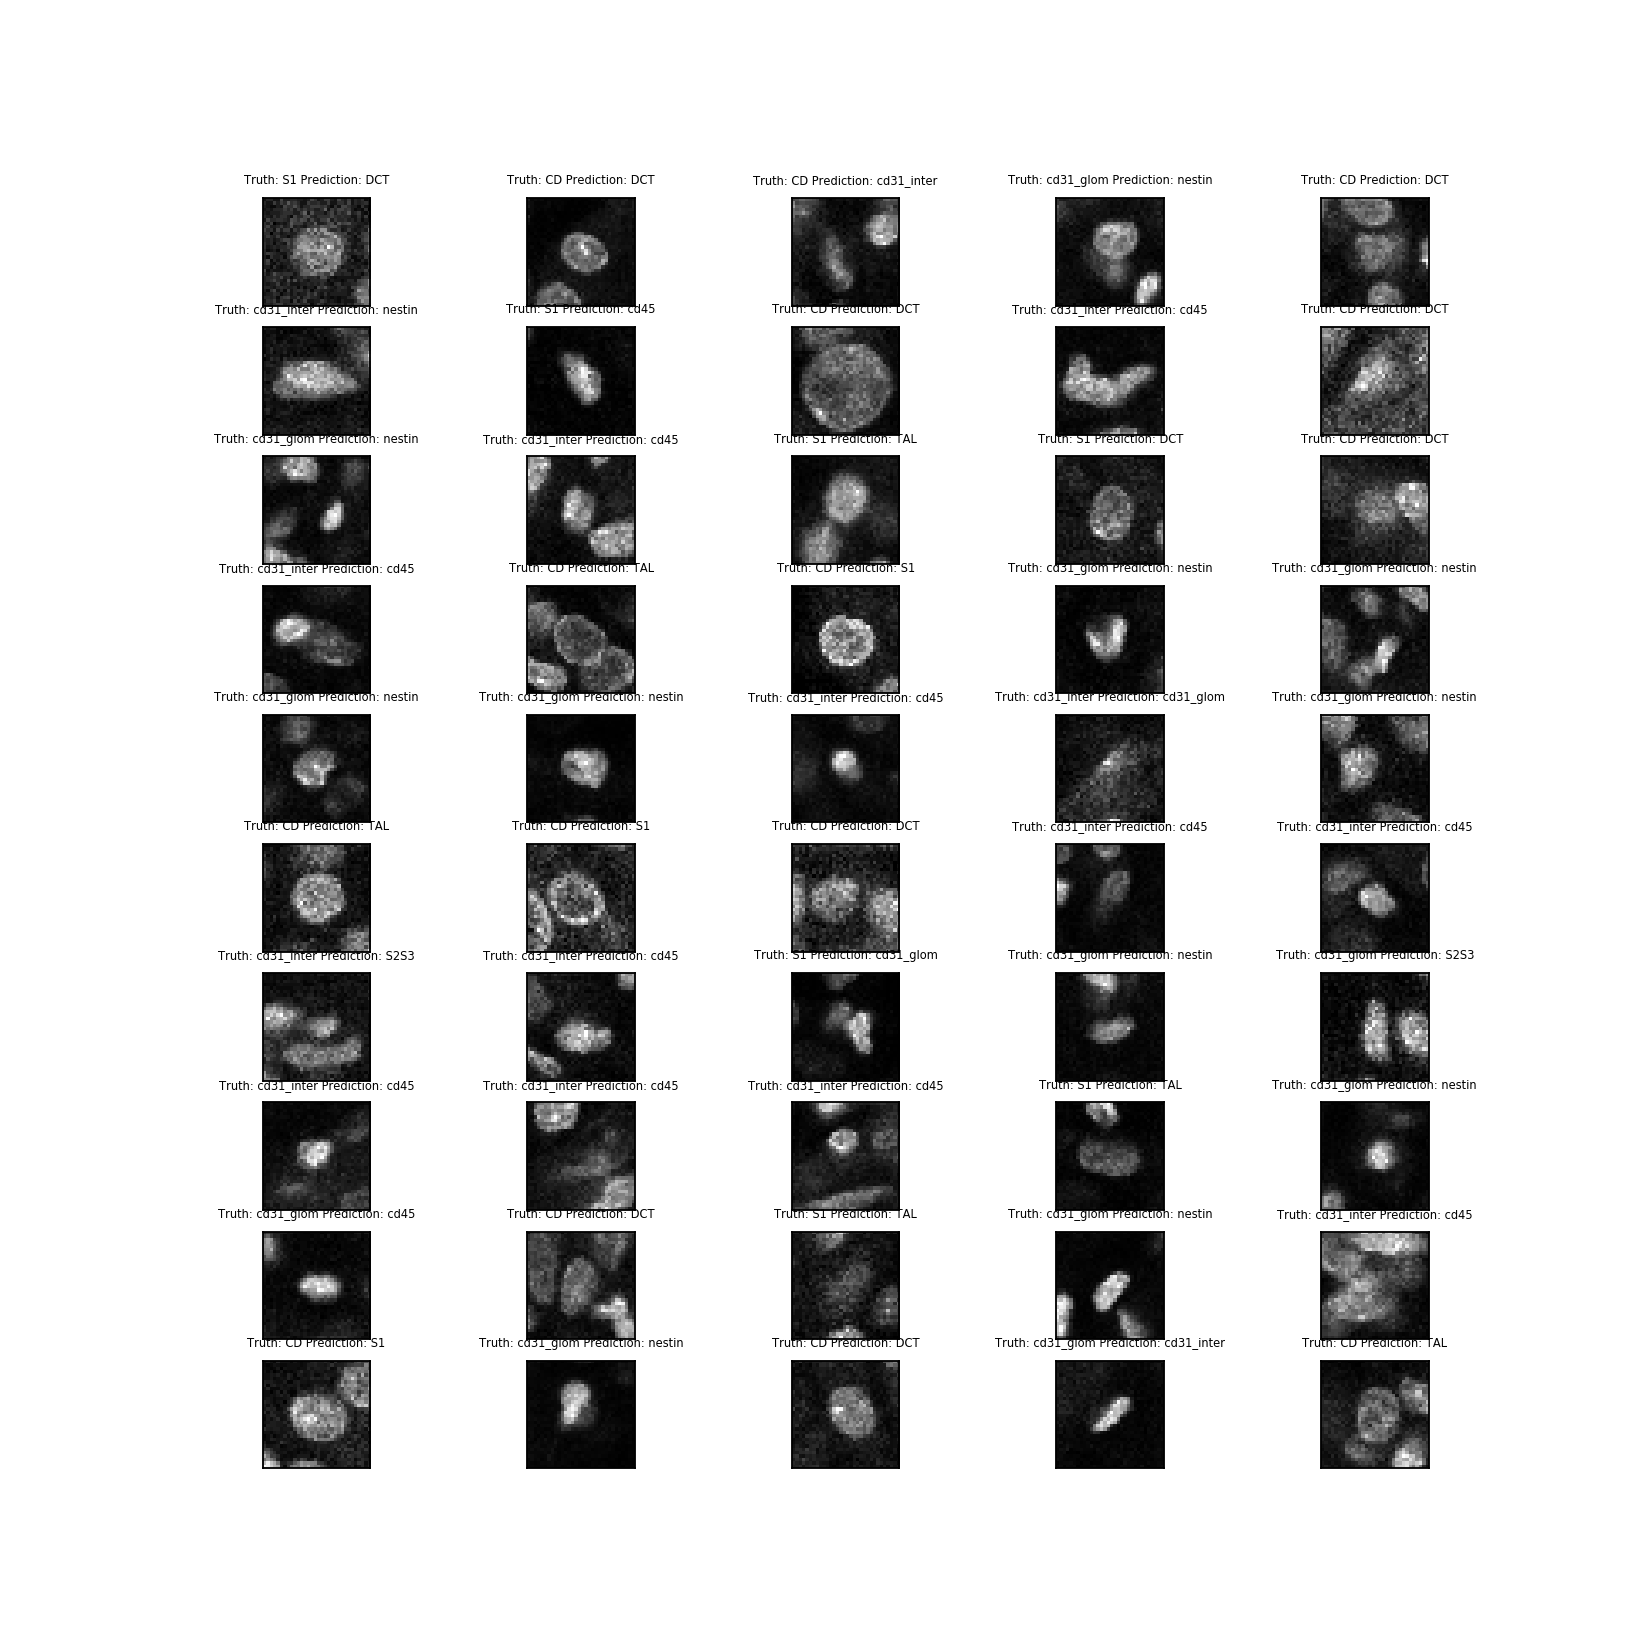

'\nremove images w/ low signal to noise \nSNR = 10*log(mean(img) / std(img))\n\n\n\n'

In [8]:
def showIm(idx, dataset, psx, classes):
    img, label = dataset.__getitem__(idx)
    img = img.data.numpy().squeeze()
    label = label
    pred = np.argmax(psx[idx])
    title = "Truth: {} Prediction: {}".format(classes[label], classes[pred])
    middle_slice = int(img.shape[0] / 2)
    plt.imshow(img[middle_slice], cmap = 'gray')
    plt.title(title)
    
    
def showIm2(idxs, dataset, psx, classes):
    imgs = []
    labels = []
    predictions = []
    for idx in range(len(idxs)):
        img, label = dataset.__getitem__(idx)
        if label == np.argmax(psx[idx]): #dont show correct
            continue
        if label == 0 and np.argmax(psx[idx]) == 1: #dont show if s1 and s2 are confused
            continue
        if label == 1 and np.argmax(psx[idx]) == 0:
            continue
        img = img.data.numpy().squeeze()
        middle_slice = int(img.shape[0] / 2)
        imgs.append(img[middle_slice])
        labels.append(label)
        predictions.append(np.argmax(psx[idx]))
    
    pw = 5
    pl = 10
    fig, axs = plt.subplots(pl, pw, figsize=(10,10),facecolor='w', edgecolor='k')
    plt.title("Random images that cleanlab thinks are labelled incorrectly")
    axs = axs.ravel()
    #fig.subplots_adjust(hspace = 0.25, wspace= -0.75)
    
    myim = np.random.choice(range(len(imgs)), pw*pl, replace = False)
    #myim = range(pw*pl)
    
    for i in range(pw*pl):
        k = myim[i] #index of random image
        title = "Truth: {} Prediction: {}".format(classes[labels[k]], classes[predictions[k]])
        axs[i].imshow(imgs[k], cmap = plt.cm.gray)
        axs[i].set_title(title, fontsize = 5)
        axs[i].set_xticks([])
        axs[i].set_yticks([])

        
#######################################################################        
        
        
label_errors_idx_train = cleanlab.pruning.order_label_errors(
    label_errors_bool = label_errors_bool_train,
    psx = psx_train,
    labels = labels_train,
    #sorted_index_method = 'normalized_margin',
    sorted_index_method = 'prob_given_label'
)
'''
label_errors_idx_test = cleanlab.pruning.order_label_errors(
    label_errors_bool = label_errors_bool_test,
    psx = psx_test,
    labels = labels_test,
    #sorted_index_method = 'normalized_margin',
    sorted_index_method = 'prob_given_label'
)
'''
classes = ('S1', 'S2S3', 'TAL', 'DCT', 'CD', 'cd45', 'nestin', 'cd31_glom', 'cd31_inter')

toShow = 30

showIm2(label_errors_idx_train, train_dataset, psx_train, classes)




#print(len(label_errors_idx))
#print(label_errors_idx[:20])

#notes
'''
remove images w/ low signal to noise 
SNR = 10*log(mean(img) / std(img))



'''

Calculated balanced accuracy after combining PCT: 0.08037511921161386
Confusion matrix, without normalization
[[6068 1675  265  184  270  209  106  660]
 [1816    0  406  129  229  113   27  236]
 [ 315  331    0  520  136   29   12   78]
 [ 254  200  832    0   56   10    0   43]
 [ 174   27  128   34    0  169  253 1041]
 [ 100   14   18    4  129    0 1682  163]
 [  29    2    4    1  137  798    0  165]
 [ 560   70   68   31 1785  325  416    0]]


<IPython.core.display.Javascript object>


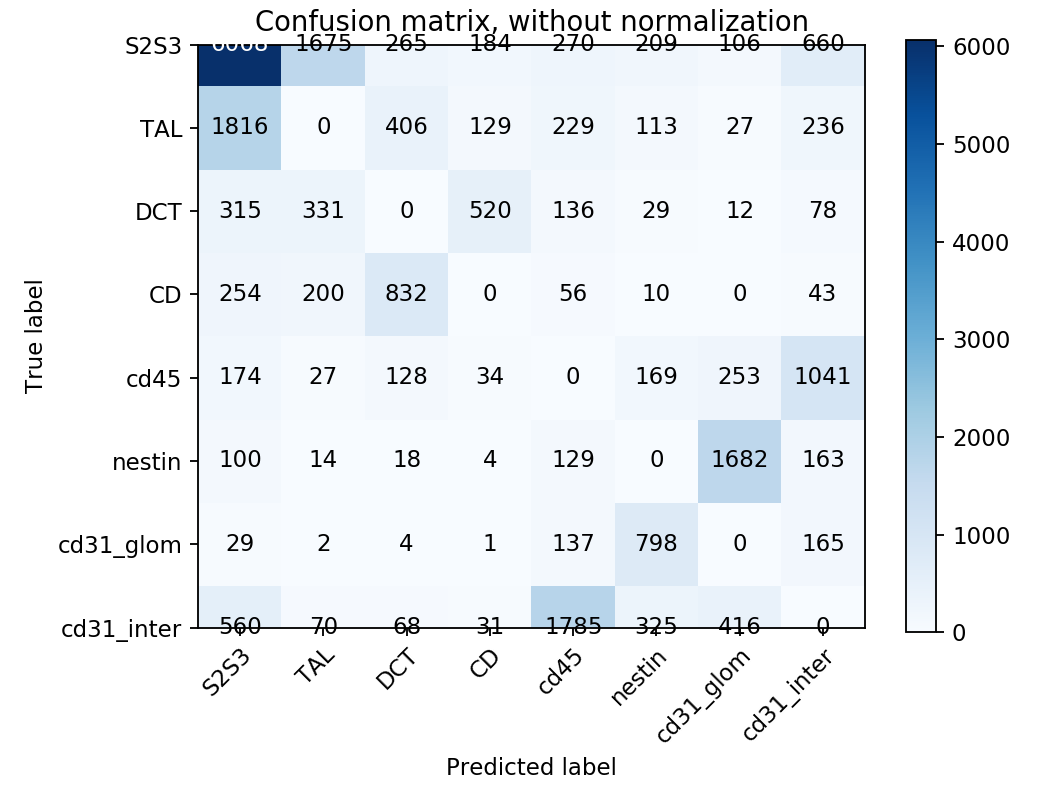

'\nall_true = np.concatenate([labels_train[label_errors_idx_train], labels_test[label_errors_idx_test]])\nall_pred = np.concatenate([psx_train.argmax(axis = 1)[label_errors_idx_train], psx_test.argmax(axis = 1)[label_errors_idx_test]]) \n\n\nprint(all_true.shape)\nprint(all_pred.shape)\n#confusion matrix of all training and testing images w/ low confidence\nutil.plot_confusion_matrix_combinePCT(all_true, all_pred, classes=classes, normalize=False)\n\n'

In [11]:
util.plot_confusion_matrix_combinePCT(labels_train[label_errors_idx_train], psx_train.argmax(axis = 1)[label_errors_idx_train], classes=classes, normalize=False)

'''
all_true = np.concatenate([labels_train[label_errors_idx_train], labels_test[label_errors_idx_test]])
all_pred = np.concatenate([psx_train.argmax(axis = 1)[label_errors_idx_train], psx_test.argmax(axis = 1)[label_errors_idx_test]]) 


print(all_true.shape)
print(all_pred.shape)
#confusion matrix of all training and testing images w/ low confidence
util.plot_confusion_matrix_combinePCT(all_true, all_pred, classes=classes, normalize=False)

'''

<IPython.core.display.Javascript object>


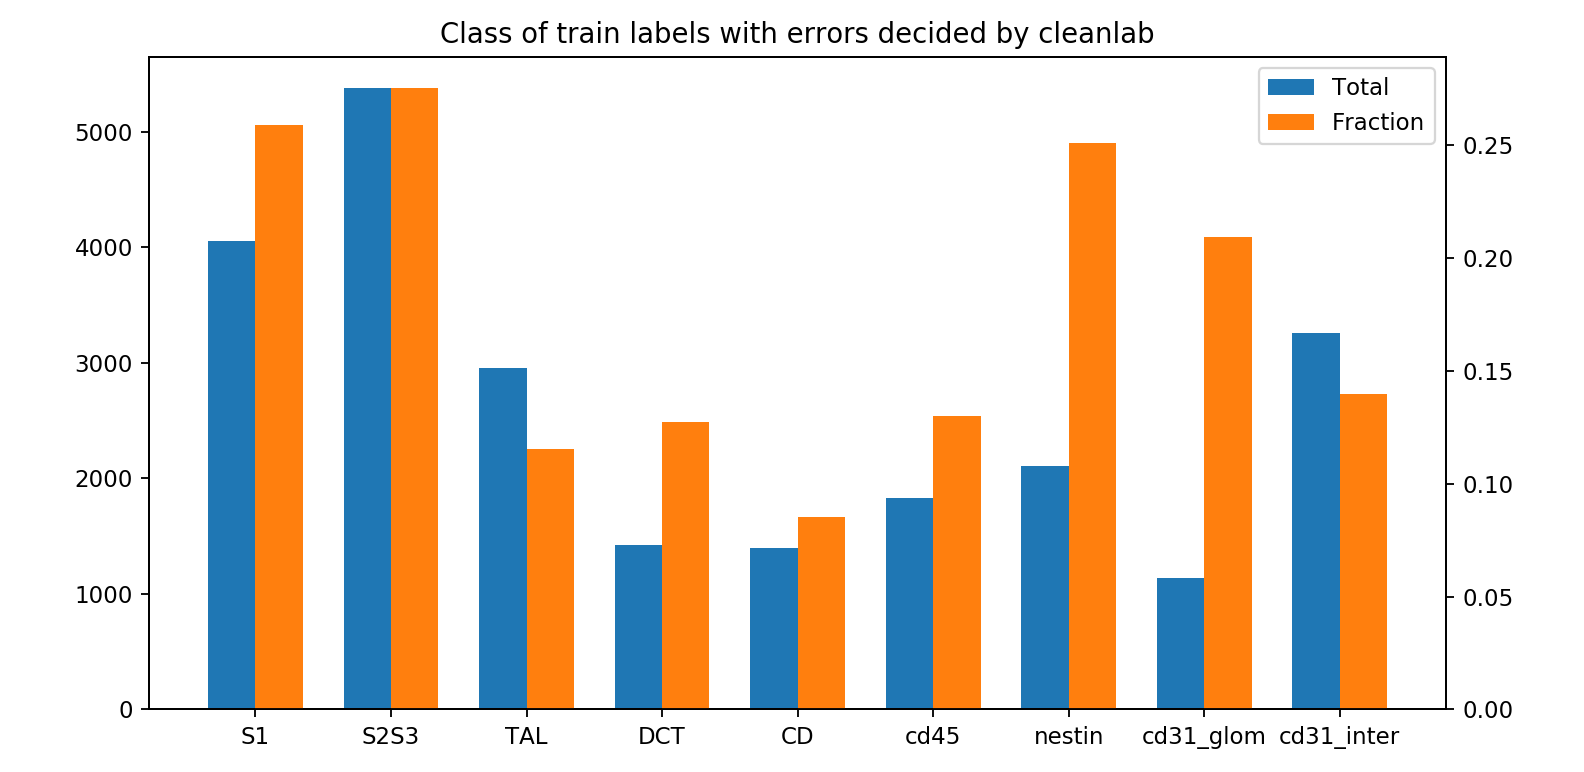

In [12]:
class_error_train = labels_train[label_errors_idx_train]
fig, ax = plt.subplots()
width = 0.35
#plt.hist(class_error_train, bins = 9)
plt.title("Class of train labels with errors decided by cleanlab")

y_pos = np.arange(len(classes))

unique, counts = np.unique(class_error_train, return_counts=True)
unique_t, counts_t = np.unique(labels_train, return_counts=True)
div = counts / counts_t

tots = ax.bar(y_pos - width/2, counts, width, label = "Total", color = 'tab:blue')
frac = ax.bar(y_pos + width/2, div, width, label = "Fraction", color = 'tab:orange')
ax.set_xticks(y_pos)
ax.set_xticklabels(classes)

ax2 = ax.twinx() 
frac = ax2.bar(y_pos + width/2, div, width, label = "Fraction", color = 'tab:orange')

ax.legend()
fig.tight_layout()
#plt.show()

<IPython.core.display.Javascript object>


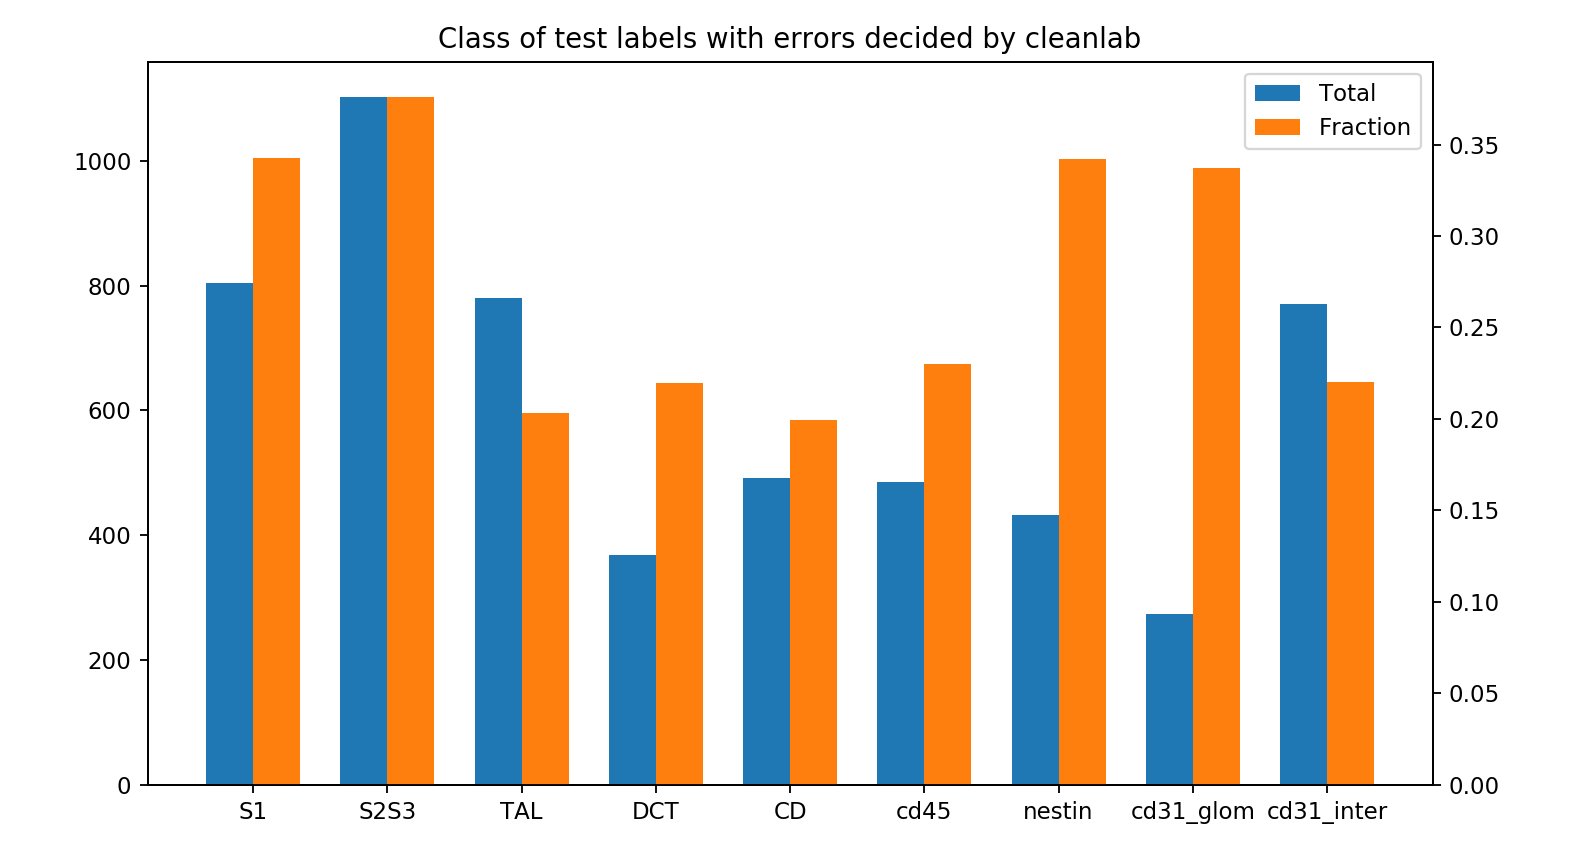

In [48]:
class_error_test = labels_test[label_errors_idx_test]
fig, ax = plt.subplots()
width = 0.35
#plt.hist(class_error_train, bins = 9)
plt.title("Class of test labels with errors decided by cleanlab")

y_pos = np.arange(len(classes))

unique, counts = np.unique(class_error_test, return_counts=True)
unique_t, counts_t = np.unique(labels_test, return_counts=True)
div = counts / counts_t

tots = ax.bar(y_pos - width/2, counts, width, label = "Total", color = 'tab:blue')
frac = ax.bar(y_pos + width/2, div, width, label = "Fraction", color = 'tab:orange')
ax.set_xticks(y_pos)
ax.set_xticklabels(classes)

ax2 = ax.twinx() 
frac = ax2.bar(y_pos + width/2, div, width, label = "Fraction", color = 'tab:orange')

ax.legend()
fig.tight_layout()
#plt.show()

In [29]:
from cleanlab.latent_estimation import estimate_py_and_noise_matrices_from_probabilities

print(np.unique(labels))

est_py, est_nm, est_inv, confident_joint_train = estimate_py_and_noise_matrices_from_probabilities(
    s=labels_train,
    psx=psx_train
)
print("fin")

print(confident_joint_train)


est_py, est_nm, est_inv, confident_joint_test = estimate_py_and_noise_matrices_from_probabilities(
    s=labels_test,
    psx=psx_test
)
print()
print(confident_joint_test)

[0 1 2 3 4 5 6 7 8]
fin
[[ 9315  3107   496   154    40    47    49     8   116]
 [ 3588 11238   691   120    42   157   221    68   498]
 [  448  1924 18099   608   101   160   164    27   229]
 [  213   149   259  8239   452    84    23    15    54]
 [  185   175   236   784 12466    53    15     4    34]
 [   43   129    10   112    44 10182   277   252   907]
 [    7   100    11     4     4    61  5339  1543    91]
 [    1    14     0     1     1    91   536  3857   113]
 [   41   453    54    55    31  1342   355   424 17041]]

[[1482  642  133   36   18   12   11    1   16]
 [ 616 1793  215   22   25   45   71   21  124]
 [  90  529 2953  101   41   34   34    7   50]
 [  47   67   81 1282  111   34   19    0   33]
 [  65   57   82  288 1940   20    1    0    9]
 [  15   68   10   27   15 1583  101   86  204]
 [   0   59   10    5    3   41  804  304   37]
 [   0    8    1    0    0   35  208  529   32]
 [   3  189   16   11    9  389   91  103 2682]]


In [13]:
#REMOVE ALL BAD LABELS FROM TRAIN DATASET
%matplotlib notebook
filename = config['data_loader']['args']['hdf5_path']
path = filename.split('.')
path = path[0] + "_prune_bad_labels.h5"
print("NEW FILE " + path)
store = pd.HDFStore(path)
with pd.HDFStore(filename) as f:
        print()
        print("Successfully created " + path)
        print("===============")
        keys = list(f.keys())
        print("{0} keys in this file: {1}".format(len(keys), keys))
        
        num_images_train = f['Metadata']['TrainingNum'][0]
        num_images_test = f['Metadata']['TestingNum'][0]
        mean = f['Metadata']['TrainingMean'][0]
        std = f['Metadata']['TrainingStd'][0]
        mean_t = np.mean(f['test_data'].to_numpy())
        std_t = np.std(f['test_data'].to_numpy())
        
        print("Training images: " + str(num_images_train))
        print("Testing images: " + str(num_images_test))
        print("Training image mean = " + str(mean) + " and std = " + str(std))
        print("Testing image mean = " + str(mean_t) + " and std = " + str(std_t))
        
        train_data = f['train_data'].to_numpy()
        train_label = f['train_labels'].to_numpy()
        
        train_data = np.delete(train_data, label_errors_idx_train, axis = 0)
        train_label = np.delete(train_label, label_errors_idx_train, axis = 0)
        
        num_images_train = len(train_data)
        snrs = np.empty(num_images_train)
        for i in range(num_images_train):
            img = train_data[i]
            img = (img - mean) / std
            snr = np.mean(img) / np.std(img)
            snrs[i] = snr
        print(len(snrs))
        print("Mean SNR: {}".format(np.mean(snrs)))
        print("Std SNR: {}".format(np.std(snrs)))

        low_snr = np.where(snrs < np.mean(snrs) - np.std(snrs))[0] #all images with SNR < 1 standard deviation from the mean
        print("Total number of low snr images {}".format(len(low_snr)))
        
        #PLOT CLASS OF IMAGES REMOVED FOR LOW SNR
        snr_train = train_label[low_snr]
        fig, ax = plt.subplots()
        width = 0.35
        #plt.hist(class_error_train, bins = 9)
        plt.title("Class of train labels with low SNR")

        y_pos = np.arange(len(classes))

        unique, counts = np.unique(snr_train, return_counts=True)
        unique_t, counts_t = np.unique(train_label, return_counts=True)
        div = counts / counts_t

        tots = ax.bar(y_pos - width/2, counts, width, label = "Total", color = 'tab:blue')
        frac = ax.bar(y_pos + width/2, div, width, label = "Fraction", color = 'tab:orange')
        ax.set_xticks(y_pos)
        ax.set_xticklabels(classes)

        ax2 = ax.twinx() 
        frac = ax2.bar(y_pos + width/2, div, width, label = "Fraction", color = 'tab:orange')

        ax.legend()
        fig.tight_layout()
        #plt.show()
        
        train_data = np.delete(train_data, low_snr, axis = 0)
        train_label = np.delete(train_label, low_snr, axis = 0)
        
        store.append('train_data', pd.DataFrame(train_data.astype(np.int64)))
        store.append('train_labels', pd.DataFrame(train_label.astype(np.int64)))
        
        
        #REPEAT FOR TEST
        test_data = f['test_data'].to_numpy()
        test_label = f['test_labels'].to_numpy()
        
        test_data = np.delete(test_data, label_errors_idx_test, axis = 0)
        test_label = np.delete(test_label, label_errors_idx_test, axis = 0)
        
        num_images_test = len(test_data)
        snrs = np.empty(num_images_test)
        for i in range(num_images_test):
            img = test_data[i]
            img = (img - mean) / std
            snr = np.mean(img) / np.std(img)
            snrs[i] = snr
        print(len(snrs))
        print("Mean SNR: {}".format(np.mean(snrs)))
        print("Std SNR: {}".format(np.std(snrs)))

        low_snr = np.where(snrs < np.mean(snrs) - np.std(snrs))[0] #all images with SNR < 1 standard deviation from the mean
        print("Total number of low snr images {}".format(len(low_snr)))
        
        
        #PLOT CLASS OF IMAGES REMOVED FOR LOW SNR
        snr_test = test_label[low_snr]
        fig, ax = plt.subplots()
        width = 0.35
        #plt.hist(class_error_train, bins = 9)
        plt.title("Class of test labels with low SNR")

        y_pos = np.arange(len(classes))

        unique, counts = np.unique(snr_test, return_counts=True)
        unique_t, counts_t = np.unique(test_label, return_counts=True)
        div = counts / counts_t

        tots = ax.bar(y_pos - width/2, counts, width, label = "Total", color = 'tab:blue')
        frac = ax.bar(y_pos + width/2, div, width, label = "Fraction", color = 'tab:orange')
        ax.set_xticks(y_pos)
        ax.set_xticklabels(classes)

        ax2 = ax.twinx() 
        frac = ax2.bar(y_pos + width/2, div, width, label = "Fraction", color = 'tab:orange')

        ax.legend()
        fig.tight_layout()
        #plt.show()
        
        test_data = np.delete(test_data, low_snr, axis = 0)
        test_label = np.delete(test_label, low_snr, axis = 0)
        
        store.append('test_data', pd.DataFrame(test_data.astype(np.int64)))
        store.append('test_labels', pd.DataFrame(test_label.astype(np.int64)))
        
        
                
        metadata = pd.DataFrame({'TrainingNum': len(train_data), 'TestingNum': len(test_data), \
                'TrainingMean': np.mean(train_data), 'TrainingStd': np.std(train_data)}, index=[0])      
        store.append('Metadata', metadata)
        store.append('test_ids', f['test_ids'])

        print(metadata)
        
        del train_data
        print("FIN")
store.close()

with pd.HDFStore(path) as f:
        print('\n\n\n')
        print("Successfully created " + path)
        print("===============")
        keys = list(f.keys())
        print("{0} keys in this file: {1}".format(len(keys), keys))

NEW FILE C:/Users/awoloshu/Desktop/datasets/f33f44_noTest/3d_all/dataset_prune_bad_labels.h5

Successfully created C:/Users/awoloshu/Desktop/datasets/f33f44_noTest/3d_all/dataset_prune_bad_labels.h5
3 keys in this file: ['/Metadata', '/train_data', '/train_labels']


KeyError: 'No object named test_data in the file'

In [51]:
#CHANGE ALL BAD LABELS IN DATASET

filename = config['data_loader']['args']['hdf5_path']
path = filename.split('.')
path = path[0] + "_clean_bad_labels.h5"
print("NEW FILE " + path)
store = pd.HDFStore(path)
with pd.HDFStore(filename) as f:
        print()
        print("Successfully created " + path)
        print("===============")
        keys = list(f.keys())
        print("{0} keys in this file: {1}".format(len(keys), keys))
        
        num_images_train = f['Metadata']['TrainingNum'][0]
        num_images_test = f['Metadata']['TestingNum'][0]
        mean = f['Metadata']['TrainingMean'][0]
        std = f['Metadata']['TrainingStd'][0]
        mean_t = np.mean(f['test_data'].to_numpy())
        std_t = np.std(f['test_data'].to_numpy())
        
        print("Training images: " + str(num_images_train))
        print("Testing images: " + str(num_images_test))
        print("Training image mean = " + str(mean) + " and std = " + str(std))
        print("Testing image mean = " + str(mean_t) + " and std = " + str(std_t))
        
        train_data = f['train_data'].to_numpy()
        train_label = f['train_labels'].to_numpy()
        #change labels
        train_label[label_errors_idx_train] = psx_train.argmax(axis = 1)[label_errors_idx_train] + 1
        
        #remove low snr images 
        num_images_train = len(train_data)
        snrs = np.empty(num_images_train)
        for i in range(num_images_train):
            img = train_data[i]
            img = (img - mean) / std
            snr = np.mean(img) / np.std(img)
            snrs[i] = snr
        print(len(snrs))
        print("Mean SNR: {}".format(np.mean(snrs)))
        print("Std SNR: {}".format(np.std(snrs)))

        low_snr = np.where(snrs < np.mean(snrs) - np.std(snrs))[0] #all images with SNR < 1 standard deviation from the mean
        print("Total number of low snr images train {}".format(len(low_snr)))
        
        train_data = np.delete(train_data, low_snr, axis = 0)
        train_label = np.delete(train_label, low_snr, axis = 0)
        
        store.append('train_data', pd.DataFrame(train_data.astype(np.int64)))
        store.append('train_labels', pd.DataFrame(train_label.astype(np.int64)))
        
        
        #REPEAT FOR TEST
        test_data = f['test_data'].to_numpy()
        test_label = f['test_labels'].to_numpy()
        
        #change labels
        test_label[label_errors_idx_test] = psx_test.argmax(axis = 1)[label_errors_idx_test] + 1
        
        snrs = np.empty(num_images_test)
        for i in range(num_images_test):
            img = test_data[i]
            img = (img - mean) / std
            snr = np.mean(img) / np.std(img)
            snrs[i] = snr
        print(len(snrs))
        print("Mean SNR: {}".format(np.mean(snrs)))
        print("Std SNR: {}".format(np.std(snrs)))

        low_snr = np.where(snrs < np.mean(snrs) - np.std(snrs))[0] #all images with SNR < 1 standard deviation from the mean
        print("Total number of low snr images test {}".format(len(low_snr)))
        
        test_data = np.delete(test_data, low_snr, axis = 0)
        test_label = np.delete(test_label, low_snr, axis = 0)
        
        store.append('test_data', pd.DataFrame(test_data.astype(np.int64)))
        store.append('test_labels', pd.DataFrame(test_label.astype(np.int64)))
        
        
                
        metadata = pd.DataFrame({'TrainingNum': len(train_data), 'TestingNum': len(test_data), \
                'TrainingMean': np.mean(train_data), 'TrainingStd': np.std(train_data)}, index=[0])      
        store.append('Metadata', metadata)
        store.append('test_ids', f['test_ids'])

        print(metadata)
        
        del train_data
        print("FIN")
store.close()

with pd.HDFStore(path) as f:
        print('\n\n\n')
        print("Successfully created " + path)
        print("===============")
        keys = list(f.keys())
        print("{0} keys in this file: {1}".format(len(keys), keys))

NEW FILE C:/Users/awoloshu/Desktop/datasets/f33f44combined_noCNT/3d_all/f33f44combined_noCNT_3d_all_clean_bad_labels.h5

Successfully created C:/Users/awoloshu/Desktop/datasets/f33f44combined_noCNT/3d_all/f33f44combined_noCNT_3d_all_clean_bad_labels.h5
6 keys in this file: ['/Metadata', '/test_data', '/test_ids', '/test_labels', '/train_data', '/train_labels']
Training images: 118681
Testing images: 20936
Training image mean = 15.022874573172926 and std = 18.438763583389793
Testing image mean = 14.399334246014213 and std = 18.52662211585272
118681
Mean SNR: -0.2847974587990564
Std SNR: 0.7188961055399377
Total number of low snr images train 13986
20936
Mean SNR: -0.2854258253268697
Std SNR: 0.7137553278666308
Total number of low snr images test 2488
   TrainingNum  TestingNum  TrainingMean  TrainingStd
0       104695       18448     15.511689    19.268343
FIN




Successfully created C:/Users/awoloshu/Desktop/datasets/f33f44combined_noCNT/3d_all/f33f44combined_noCNT_3d_all_clean_bad_la